In [ ]:
import os
import re
import time
import datetime
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.colors import Colormap
%matplotlib inline

import jieba
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models





c:\Users\rolya\anaconda3\envs\Syllabus\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


# ‰∏ªÈ°å : Ê†∏ÈõªË≠∞È°åÁöÑÊ∞ëÊÑèËàáÊîøË¶ãÂàÜÊûê
# ÂãïÊ©ü
Âæû‰∏çÂêåËßíÂ∫¶ (Ê∞ëÁúæ„ÄÅÊîøÈª®) ËßÄÂØüÂè∞ÁÅ£Â∞çÊñºÊ†∏ÈõªÂª†ÁöÑÊÖãÂ∫¶ÔºåÂàÜÊûêÂ±§Èù¢Â§ßÊ¶ÇÊúÉÂàÜÊàêÂÖ©Á®Æ : 
+ ### Ê∞ëÁúæÂ±§Èù¢
    + Âà©Áî® PTTÔºàÂÖ´Âç¶Êùø„ÄÅÊîøÈªëÊùøÔºâÊñáÁ´†ÈÄ≤Ë°åÊÉÖÁ∑íÂàÜÊûêÔºåÊé¢Ë®éË®éË´ñÊ†∏ÈõªË≠∞È°åÊôÇÁöÑÊ≠£Ë≤†ÂêëÊÉÖÁ∑íËÆäÂåñËàáË∂®Âã¢
    + ÂàÜÊûê‰∏çÂêåÊôÇÈñìÈªû‰∏äÊ∞ëÁúæÊÉÖÁ∑íÁöÑÈ´ò‰ΩéËàáÊ≥¢ÂãïÔºå‰∏¶ÂòóË©¶ÈóúËÅØÁâπÂÆöÁ§æÊúÉ‰∫ã‰ª∂ÊàñÊîøÊ≤ªËÉåÊôØ
+ ### ÊîøÈª®Â±§Èù¢
  + ÈÄèÈÅé‰∏ªÈ°åÊ®°ÂûãÂàÜÊûêÊîøÈª®ËàáÊ†∏ÈõªË≠∞È°åÁöÑÈóúËÅØ‰∏ªÈ°å

# Ë≥áÊñô‰ªãÁ¥π - Ê†∏Èõª
+ Ë≥áÊñô‰æÜÊ∫ê : PTT
+ ÁúãÊùø : ÊîøÈªë (HatePlitics)„ÄÅÂÖ´Âç¶ (Gossiping)
+ ÊôÇÈñì : 2021/7 ~ 2025/6

# ÂΩ±ÁâáÈÄ£Áµê : https://youtu.be/FIakCeG6M5k


# Ë≥áÊñôÂâçËôïÁêÜ

## ÂåØÂÖ•Ë≥áÊñô

In [347]:
df1 = pd.read_csv("HatePolitics.csv")
df2 = pd.read_csv("Gossiping.csv")

df = pd.concat([df1, df2], ignore_index=True)
df.to_csv("PTT_Nuclear.csv", index=False, encoding="utf-8-sig")

df["artDate"] = pd.to_datetime(df["artDate"])
df['artDate'] = df['artDate'].dt.date 
df.head()

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/HatePolitics/M.16224802...   
1          2  https://www.ptt.cc/bbs/HatePolitics/M.16225748...   
2          3  https://www.ptt.cc/bbs/HatePolitics/M.16226249...   
3          4  https://www.ptt.cc/bbs/HatePolitics/M.16226918...   
4          5  https://www.ptt.cc/bbs/HatePolitics/M.16231218...   

                      artTitle     artDate    artPoster   artCatagory  \
0      [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü  2021-06-01  chihchingho  HatePolitics   
1        Re:[ÈªëÁâπ]Ê∞ëÈÄ≤Èª®20222024ÊÄéÈ∫ºÈÅ∏  2021-06-02    larrytang  HatePolitics   
2              [Ë®éË´ñ]Ê∞ëÈÄ≤Èª®ÊØîËºÉÈÅ©ÂêàÁï∂Âú®ÈáéÈª®  2021-06-02   stevencool  HatePolitics   
3     [Êñ∞ËÅû]ÈüìÁí∞ÂúòÂá∫Âãï100Â§öËâòÊºÅËàπÂèçÂ∞çÊó•Êú¨ÊéíÊ†∏Âª¢Ê∞¥  2021-06-03       CRESTY  HatePolitics   
4  Re:[Êñ∞ËÅû]5ÊúàÂ∫ïË´ãËæ≠Èô≥ÂüπÂì≤:ÊúÄÂ§ßÂõ∞Èõ£Â∞±ÊòØ‰æÜËá™Ëî°Ëã±Êñá  2021-06-08       areses  HatePolitics   

                                          artContent  \
0  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...   
1  Áèæ‰ªªÈ¶¨ÈáåËò≠Â∑ûÂ∑ûÈï∑Larry HoganÂõ†ÁÇ∫Â§™Â§™ÊòØÈüìÂúãÁ¨¨‰∏Ä‰ª£ÁßªÊ∞ëÔºåÂ∞çÁßªÊ∞ëÈùûÂ∏∏ÂèãÂ•ΩÔºå‰πüÂõ†Ê≠§Â∞ç‰∏≠Âúã...   
2  2008Âπ¥ÈÇ£Ê¨°Á´ãÂßîÂâ©27Â∏≠\n\nÈª®ÂúòÁ∏ΩÂè¨ÊüØÂª∫Èäò Âππ‰∫ãÈï∑Ë≥¥Ê∏ÖÂæ∑\n\nÁõ£Áù£Ëµ∑È¶¨ÊîøÂ∫úÊòØËôéËôéÁîüÈ¢®...   
3  1.Êñ∞ËÅûÁ∂≤ÂùÄÔ∏∞\nhttps://news.ltn.com.tw/news/world/br...   
4  ÈõñÁÑ∂ÊàëÂÄë‰∏ÄÁõ¥Ë™™ÊîøÊ≤ª‰∏çËÉΩÂáåÈßïÊñºÁßëÂ≠∏Ôºå‰ΩÜÈÇ£ÊòØÊ≠£Â∏∏ÊÉÖÊ≥Å‰∏ãÔºåÊîøÊ≤ªÊú¨‰æÜÂ∞±ÊòØ‰∏ÄÂàáÁ§æÊúÉÈóú‰øÇÁöÑÁ∏Ω\nÂíåÔºå‰πüÊòØ...   

                                          artComment             e_ip  \
0  [{"cmtStatus": "‚Üí", "cmtPoster": "Tattoo", "cm...   223.140.25.201   
1  [{"cmtStatus": "Êé®", "cmtPoster": "taipoo", "cm...  174.244.210.225   
2  [{"cmtStatus": "‚Üí", "cmtPoster": "icolee", "cm...     1.174.11.170   
3  [{"cmtStatus": "‚Üí", "cmtPoster": "dakkk", "cmt...      27.242.3.80   
4  [{"cmtStatus": "Âôì", "cmtPoster": "JamesSoong",...   223.104.20.205   

          insertedDate dataSource  
0  2021-06-01 03:10:22        ptt  
1  2021-06-03 03:02:08        ptt  
2  2021-06-03 03:04:06        ptt  
3  2021-06-04 01:43:23        ptt  
4  2021-06-09 01:53:43        ptt

## Ë≥áÊñôÊ∏ÖÁêÜ

In [348]:
clear_df = df.copy()

#ÂéªÈô§Êú¨Ê¨°‰∏çÊúÉÁî®Âà∞ÁöÑÊ¨Ñ‰Ωç
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#ÂéªÈô§ÊñáÁ´†ÂÖßÂÆπÁÇ∫Á©∫ÂÄºÁöÑÁ≠ÜÊï∏
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#Êñ∞Â¢û['sentence']Ê¨Ñ‰ΩçÔºåÁî®'„ÄÇ'Âèñ‰ª£'\n\n'Ôºå‰∏¶ÁßªÈô§'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','„ÄÇ', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','', regex=True)

#ÁßªÈô§ÂÖßÊñá‰∏≠ÁöÑÁ∂≤ÂùÄ
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df.head()

artUrl  \
0  https://www.ptt.cc/bbs/HatePolitics/M.16224802...   
1  https://www.ptt.cc/bbs/HatePolitics/M.16225748...   
2  https://www.ptt.cc/bbs/HatePolitics/M.16226249...   
3  https://www.ptt.cc/bbs/HatePolitics/M.16226918...   
4  https://www.ptt.cc/bbs/HatePolitics/M.16231218...   

                      artTitle     artDate  \
0      [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü  2021-06-01   
1        Re:[ÈªëÁâπ]Ê∞ëÈÄ≤Èª®20222024ÊÄéÈ∫ºÈÅ∏  2021-06-02   
2              [Ë®éË´ñ]Ê∞ëÈÄ≤Èª®ÊØîËºÉÈÅ©ÂêàÁï∂Âú®ÈáéÈª®  2021-06-02   
3     [Êñ∞ËÅû]ÈüìÁí∞ÂúòÂá∫Âãï100Â§öËâòÊºÅËàπÂèçÂ∞çÊó•Êú¨ÊéíÊ†∏Âª¢Ê∞¥  2021-06-03   
4  Re:[Êñ∞ËÅû]5ÊúàÂ∫ïË´ãËæ≠Èô≥ÂüπÂì≤:ÊúÄÂ§ßÂõ∞Èõ£Â∞±ÊòØ‰æÜËá™Ëî°Ëã±Êñá  2021-06-08   

                                          artContent  \
0  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...   
1  Áèæ‰ªªÈ¶¨ÈáåËò≠Â∑ûÂ∑ûÈï∑Larry HoganÂõ†ÁÇ∫Â§™Â§™ÊòØÈüìÂúãÁ¨¨‰∏Ä‰ª£ÁßªÊ∞ëÔºåÂ∞çÁßªÊ∞ëÈùûÂ∏∏ÂèãÂ•ΩÔºå‰πüÂõ†Ê≠§Â∞ç‰∏≠Âúã...   
2  2008Âπ¥ÈÇ£Ê¨°Á´ãÂßîÂâ©27Â∏≠\n\nÈª®ÂúòÁ∏ΩÂè¨ÊüØÂª∫Èäò Âππ‰∫ãÈï∑Ë≥¥Ê∏ÖÂæ∑\n\nÁõ£Áù£Ëµ∑È¶¨ÊîøÂ∫úÊòØËôéËôéÁîüÈ¢®...   
3  1.Êñ∞ËÅûÁ∂≤ÂùÄÔ∏∞\nhttps://news.ltn.com.tw/news/world/br...   
4  ÈõñÁÑ∂ÊàëÂÄë‰∏ÄÁõ¥Ë™™ÊîøÊ≤ª‰∏çËÉΩÂáåÈßïÊñºÁßëÂ≠∏Ôºå‰ΩÜÈÇ£ÊòØÊ≠£Â∏∏ÊÉÖÊ≥Å‰∏ãÔºåÊîøÊ≤ªÊú¨‰æÜÂ∞±ÊòØ‰∏ÄÂàáÁ§æÊúÉÈóú‰øÇÁöÑÁ∏Ω\nÂíåÔºå‰πüÊòØ...   

                                            sentence  
0  Â§ßÂÆ∂ÂÆâÂÆâ„ÄÇËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû„ÄÇ20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó‰∫Ü„ÄÇËî°ÊîøÂ∫úÁ¨¨...  
1  Áèæ‰ªªÈ¶¨ÈáåËò≠Â∑ûÂ∑ûÈï∑Larry HoganÂõ†ÁÇ∫Â§™Â§™ÊòØÈüìÂúãÁ¨¨‰∏Ä‰ª£ÁßªÊ∞ëÔºåÂ∞çÁßªÊ∞ëÈùûÂ∏∏ÂèãÂ•ΩÔºå‰πüÂõ†Ê≠§Â∞ç‰∏≠Âúã...  
2  2008Âπ¥ÈÇ£Ê¨°Á´ãÂßîÂâ©27Â∏≠„ÄÇÈª®ÂúòÁ∏ΩÂè¨ÊüØÂª∫Èäò Âππ‰∫ãÈï∑Ë≥¥Ê∏ÖÂæ∑„ÄÇÁõ£Áù£Ëµ∑È¶¨ÊîøÂ∫úÊòØËôéËôéÁîüÈ¢®„ÄÇËî°Ëã±ÊñáÁöÑÁ¨¨...  
3  1.Êñ∞ËÅûÁ∂≤ÂùÄÔ∏∞ ÂèçÂ∞çÊó•Êú¨ÊéíÊ†∏Âª¢Ê∞¥ÂÖ•Êµ∑4.ÂÆåÊï¥Êñ∞ËÅûÂÖßÂÆπÔ∏∞2021/06/02 20:57„ÄîÂç≥ÊôÇ...  
4  ÈõñÁÑ∂ÊàëÂÄë‰∏ÄÁõ¥Ë™™ÊîøÊ≤ª‰∏çËÉΩÂáåÈßïÊñºÁßëÂ≠∏Ôºå‰ΩÜÈÇ£ÊòØÊ≠£Â∏∏ÊÉÖÊ≥Å‰∏ãÔºåÊîøÊ≤ªÊú¨‰æÜÂ∞±ÊòØ‰∏ÄÂàáÁ§æÊúÉÈóú‰øÇÁöÑÁ∏ΩÂíåÔºå‰πüÊòØÊéßÂà∂...

## Êñ∑Âè•

In [349]:
clear_df['sentence'] = clear_df['sentence'].str.split("[,Ôºå„ÄÇÔºÅ!Ôºü?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)

sent_df.head()

artUrl                 artTitle  \
0  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü   
1  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü   
2  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü   
3  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü   
4  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü   

      artDate                                         artContent  \
0  2021-06-01  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...   
1  2021-06-01  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...   
2  2021-06-01  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...   
3  2021-06-01  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...   
4  2021-06-01  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...   

                  sentence  
0                     Â§ßÂÆ∂ÂÆâÂÆâ  
1  ËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû  
2             20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó‰∫Ü  
3       Ëî°ÊîøÂ∫úÁ¨¨‰∏Ä‰ªªÊäìËëóÂ∞èËæÆÂ≠êÂç°ÁÆ°‰∏≠ÈñîÁï∂Ê†°Èï∑  
4                ÁµêÊûúÈÇÑÊòØË¶ÅÁµ¶‰ªñËÅòÊõ∏

In [350]:
jieba.set_dictionary('dict.txt')

In [351]:
#ÂéªÈô§Âè•Â≠ê‰∏≠Èô§‰∫ÜÂ≠óÊØç„ÄÅÊï∏Â≠ó„ÄÅÁ©∫ÁôΩÂ≠óÁ¨¶‰ª•Â§ñÁöÑÁ¨¶Ëôü
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# ÊääÈï∑Â∫¶Â∞èÊñº1ÁöÑsentenceÂà™Êéâ
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df.head()

artUrl                 artTitle  \
0  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü   
1  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü   
2  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü   
3  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü   
4  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü   

      artDate                                         artContent  \
0  2021-06-01  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...   
1  2021-06-01  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...   
2  2021-06-01  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...   
3  2021-06-01  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...   
4  2021-06-01  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...   

                  sentence  
0                     Â§ßÂÆ∂ÂÆâÂÆâ  
1  ËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû  
2             20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó‰∫Ü  
3       Ëî°ÊîøÂ∫úÁ¨¨‰∏Ä‰ªªÊäìËëóÂ∞èËæÆÂ≠êÂç°ÁÆ°‰∏≠ÈñîÁï∂Ê†°Èï∑  
4                ÁµêÊûúÈÇÑÊòØË¶ÅÁµ¶‰ªñËÅòÊõ∏

## ÊñáÁ´†Êñ∑Ë©û

In [352]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#ÂéªÈô§Â∞ëÊñºÂÖ©ÂÄãÂ≠óÁöÑË©ûË™û
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df.head()

Building prefix dict from c:\Users\rolya\Downloads\Á§æÁæ§ÊúüÊú´\dict.txt ...
Loading model from cache C:\Users\rolya\AppData\Local\Temp\jieba.u79b1ff2e48bc0a968a496524a112d88f.cache
Loading model cost 0.647 seconds.
Prefix dict has been built successfully.


artUrl                 artTitle  \
0  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü   
0  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü   
1  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü   
1  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü   
1  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü   

      artDate                                         artContent word  
0  2021-06-01  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...   Â§ßÂÆ∂  
0  2021-06-01  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...   ÂÆâÂÆâ  
1  2021-06-01  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...  ËÄÅÂØ¶Ë™™  
1  2021-06-01  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...  Ê∞ëÈÄ≤Èª®  
1  2021-06-01  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...   ÊîøÂ∫ú

## ÁßªÈô§ÂÅúÁî®Â≠ó

In [353]:
stopwords = [line.strip() for line in open('stopwords.txt', 'r', encoding='utf-8').readlines()] 
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df.head()

artUrl                 artTitle  \
0  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü   
1  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü   
1  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü   
1  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü   
1  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü   

      artDate                                         artContent word  
0  2021-06-01  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...   ÂÆâÂÆâ  
1  2021-06-01  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...  ËÄÅÂØ¶Ë™™  
1  2021-06-01  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...  Ê∞ëÈÄ≤Èª®  
1  2021-06-01  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...   ÊîøÂ∫ú  
1  2021-06-01  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...   Áü•ÈÅì

# Lexicon-based ÊÉÖÁ∑íÂàÜÊûê

## ÊÉÖÁ∑íÂ≠óÂÖ∏ËàáÊñ∑Ë©ûÁµêÊûúÈÄ≤Ë°åÂêà‰Ωµ

In [354]:
# ËÆÄÂèñÊÉÖÁ∑íÂ≠óÂÖ∏
liwc_dict = pd.read_csv("./LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})

ptt_liwc_df = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
ptt_liwc_df.head()

artUrl     artDate  \
0  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  2021-06-01   
1  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  2021-06-01   
2  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  2021-06-01   
3  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  2021-06-01   
4  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  2021-06-01   

                  artTitle                                         artContent  \
0  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...   
1  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...   
2  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...   
3  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...   
4  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...   

  word sentiments  
0   ÂÆâÂÆâ        NaN  
1  ËÄÅÂØ¶Ë™™        NaN  
2  Ê∞ëÈÄ≤Èª®        NaN  
3   ÊîøÂ∫ú        NaN  
4   Áü•ÈÅì        NaN

## Ê≠£Ë≤†ÂêëÊÉÖÁ∑íË©ûÂΩôÈ†ªÁéáÊäòÁ∑öÂúñ

In [355]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count.head(10)

artDate sentiments  size
2   2021-06-01   negative    11
6   2021-06-02   negative    18
7   2021-06-02   positive    14
12  2021-06-03   negative    11
13  2021-06-03   positive    17
17  2021-06-04   negative     7
18  2021-06-04   positive     6
24  2021-06-06   positive    15
23  2021-06-06   negative    17
28  2021-06-07   negative    22

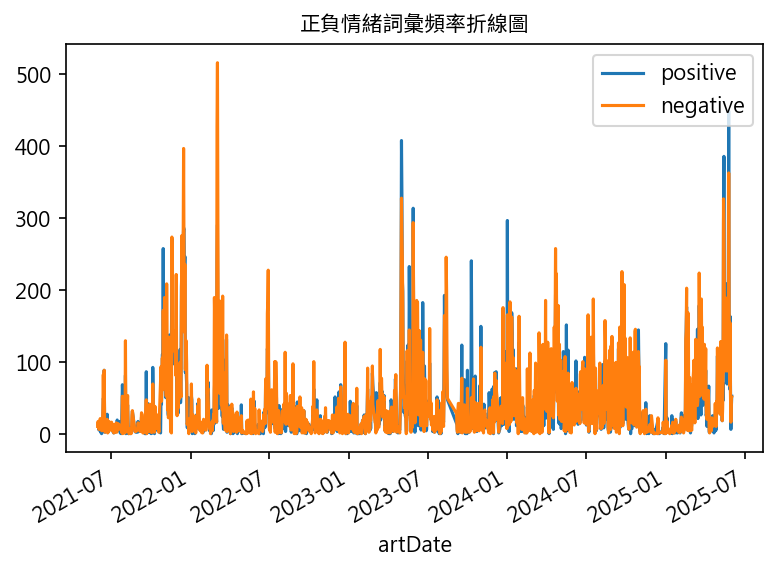

In [356]:
# plt.rcParams['font.sans-serif']=['SimHei'] #‰Ωø matplotilb ‰∏≠ÊñáËÉΩÊ≠£Â∏∏È°ØÁ§∫
fprop = fm.FontProperties(fname="SourceHanSansTW-Regular.otf")

# Ë®≠ÂÆöÊï¥‰ªΩ notebook ÂúñÁâáÁöÑÈï∑ÂØ¨Ëàá dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # ‰πüÂèØ‰ª•Âú®Ë©≤ÂúñË®≠ÂÆöÂèÉÊï∏
fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("Ê≠£Ë≤†ÊÉÖÁ∑íË©ûÂΩôÈ†ªÁéáÊäòÁ∑öÂúñ", fontproperties=fprop)  # Ë®òÂæóÂä†‰∏äÊâçËÉΩÈ°ØÁ§∫‰∏≠Êñá
plt.show()


negativeÊ≥¢ÂãïËºÉÂ§ßÔºåÂ∏∏Âá∫ÁèæÈ´òÂ≥∞Ôºö‰ª£Ë°®Êï¥È´îËÄåË®ÄÔºåË≤†Èù¢ÊÉÖÁ∑íÂú®Ë®éË´ñÊ†∏ÈõªÊôÇ‰ΩîÊØîËºÉÈ´òÔºåÂ∞§ÂÖ∂Âú®Êüê‰∫õ‰∫ã‰ª∂ÁàÜÁôºÊôÇÊúÉÊúâÊ•µÂ§ßÊ≥¢ÂãïÔºà‰æãÂ¶ÇÁ†¥ 400ÔΩû500 ÁöÑÈ´òÂ≥∞Ôºâ„ÄÇ<br>
positiveÁõ∏Â∞çÂπ≥Á©©‰ΩÜËºÉÂº±Âã¢ÔºöÊ≠£ÂêëË©ûÂΩôÁöÑ‰ΩøÁî®È†ªÁéáÊòéÈ°Ø‰ΩéÊñºË≤†Èù¢Ë©ûÂΩôÔºåÂπæ‰πéÊ≤íÊúâ‰∏ªÂ∞éÈÅéÊÉÖÁ∑íË®éË´ñ„ÄÇ<br>

ÊôÇÈñì‰∏äÁúãÔºåË≤†Èù¢È´òÂ≥∞Â§öÂá∫ÁèæÂú®Ôºö<br>
2022Âπ¥ÂàùÔºöÂèØËÉΩËàáËÉΩÊ∫êÊîøÁ≠ñ„ÄÅÈõªÂÉπ„ÄÅÊ†∏ÂõõÁà≠Ë≠∞Áõ∏Èóú„ÄÇ<br>
2024Âπ¥Ëàá2025Âπ¥Âàù‰πüÊúâÂ§öÊ¨°Â∞èÊ≥¢ÂãïÔºåÂèØËÉΩËàáÈÅ∏Ëàâ„ÄÅ‰∫ãÊïÖÊàñËÉΩÊ∫êÁü≠Áº∫Ë®éË´ñÊúâÈóú„ÄÇ<br>

ÂàùÊ≠•Êé®Ë´ñÔºöÊ∞ëÁúæÂ∞çÊ†∏ÈõªË≠∞È°åÁöÑÊÉÖÁ∑íÂÅèÂêëË≤†Èù¢ÔºåÊ≠£Èù¢ËÅ≤Èü≥ËºÉÂ∞ëËÄåÂàÜÊï£ÔºåÈ´òÂ≥∞Â∏∏ËàáÊîøÊ≤ªÊàñ‰∫ã‰ª∂È©ÖÂãïÊúâÈóú„ÄÇ

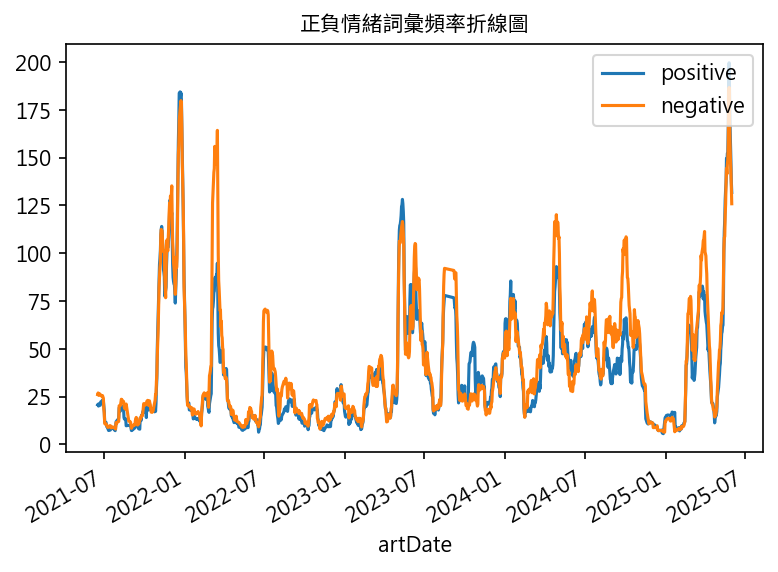

In [357]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # ‰πüÂèØ‰ª•Âú®Ë©≤ÂúñË®≠ÂÆöÂèÉÊï∏
fig, ax = plt.subplots()

# ‰ΩøÁî® Series.rolling().mean() ‰æÜÁî¢Áîü 14 Â§©Âπ≥Âùá
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("Ê≠£Ë≤†ÊÉÖÁ∑íË©ûÂΩôÈ†ªÁéáÊäòÁ∑öÂúñ", fontproperties=fprop)  # Ë®òÂæóÂä†‰∏äÊâçËÉΩÈ°ØÁ§∫‰∏≠Êñá
plt.show()

Ê≠£Ë≤†ÊÉÖÁ∑íÂ∑ÆË∑ùÁ∏ÆÂ∞èÔºöÈ°ØÁ§∫Ë®éË´ñÈÄêÊº∏Â§öÂÖÉÔºåÂèØËÉΩÂá∫Áèæ‰∫ÜÊõ¥Â§öÁ´ãÂ†¥‰∫§ÈãíÊàñÁêÜÊÄßË®éË´ñÔºåËÄå‰∏çÂÜçÊòØÂñÆÂêëÁöÑË≤†Èù¢‰∏ªÂ∞é„ÄÇ<br>

ÂπæÊ¨°ÊòéÈ°ØÁöÑÂêåÊ≠•Ê≥¢ÂãïÈªûÔºö<br>
2022Âπ¥ÂàùÔºöÊòéÈ°ØÈ´òÂ≥∞„ÄÇ<br>
2023Âπ¥‰∏≠Ëàá2025Âπ¥ÂàùÔºö‰πüÊúâÊòéÈ°ØÊ≥¢ÂãïÔºåÂèØËÉΩÂ∞çÊáâÁâπÂÆöÈáçÂ§ßÊñ∞ËÅûÊàñÁ§æÊúÉ‰∫ã‰ª∂„ÄÇ<br>

Êé®Ë´ñË£úÂÖÖÔºö<br>
Âπ≥ÊªëÂúñÂèçÊò†Âá∫Êï¥È´îË®éË´ñÊ∞õÂúçÁöÑË∂®Âã¢ÔºåÊúâÈÄêÊ≠•Êúù„ÄåÊÉÖÁ∑íÂ∞çÁ´ã‰ΩÜÂùáË°°„ÄçÁöÑÊñπÂêëËµ∞„ÄÇ<br>
Âæû2023Âπ¥‰ª•ÂæåÔºåÊ≠£Èù¢ÊÉÖÁ∑íÈõñ‰ªçËºÉÂº±Ôºå‰ΩÜÂ∑≤‰∏çÂÜçÂÆåÂÖ®ÈÇäÁ∑£ÂåñÔºåÂèçÊò†Êüê‰∫õË®ÄË´ñÁ©∫ÈñìÊì¥Â§ßÊàñÊîØÊåÅÊ†∏ËÉΩÁöÑËÅ≤Èü≥ÈÄêÊ≠•ÊµÆÁèæ„ÄÇ

## Ê≠£Ë≤†ÂêëÊÉÖÁ∑íË©ûÂΩôÊØî‰æãÊäòÁ∑öÂúñ

Text(0.5, 1.0, 'Ê≠£Ë≤†ÊÉÖÁ∑íÊØî‰æãÊäòÁ∑öÂúñ')

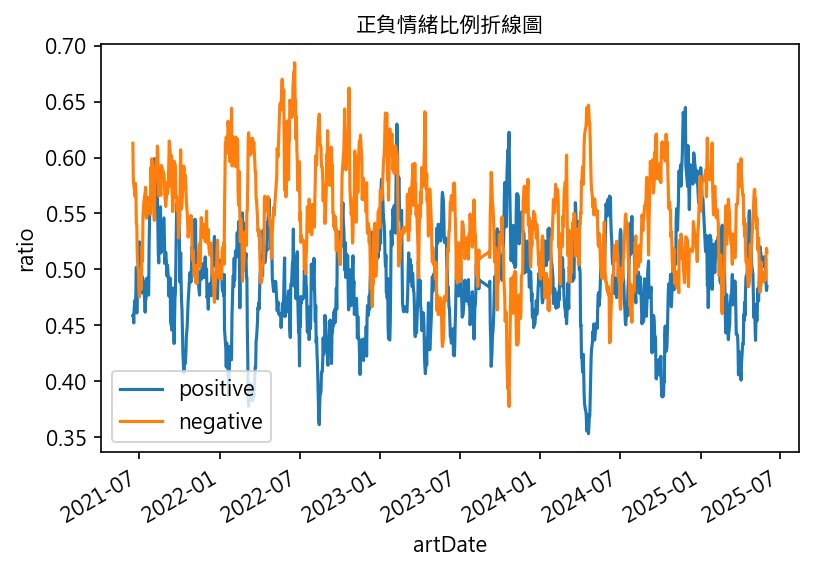

In [358]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)

pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("Ê≠£Ë≤†ÊÉÖÁ∑íÊØî‰æãÊäòÁ∑öÂúñ", fontproperties=fprop)

negativeÂ§ßÂ§öÊï∏ÊôÇÈñìÊØîpositiveÈ´òÔºå‰ª£Ë°®Âú®Â§öÊï∏ÊôÇÊúüË≤†Èù¢Ë©ûÁöÑ‰ΩîÊØîÈ´òÊñºÊ≠£Èù¢Ë©û„ÄÇ<br>

ÈõñÁÑ∂ÂÖ©ËÄÖÁöÜÂú® 0.4ÔΩû0.65 ÈñìÊ≥¢ÂãïÔºå‰ΩÜÊï¥È´îËßÄÂØü‰∏ã‰æÜÔºö<br>
2022 Âπ¥ÂàùÔΩû‰∏≠ÔºöË≤†Èù¢ÊØî‰æãÈ°ØËëóÈ´òÔºàÈÅîÂà∞ 0.65ÔºâÔºåÊáâÁÇ∫‰∫ã‰ª∂È´òÂ≥∞Êúü„ÄÇ<br>
2024 Âπ¥‰∏≠‰ª•ÂæåÔºöÊ≠£Ë≤†ÊØî‰æãÈñãÂßãÂá∫ÁèæÂ§öÊ¨°‰∫§ÂèâÔºå‰ª£Ë°®ÊÑèË¶ãË∂®ÊñºÂπ≥Ë°°ÊàñÁà≠Ë´ñÂçáÊ∫´„ÄÇ<br>

Âá∫Áèæ„ÄåÊ≠£Èù¢ÊØî‰æãÊòéÈ°Ø‰∏äÂçá„ÄçÁöÑÊôÇÈñìÔºö<br>
2023 Âπ¥‰∏≠Ëàá 2025 Âπ¥‰∏≠ÂæåÔºåÈ°ØÁ§∫Ë®éË´ñ‰∏≠ÊúâË∂ä‰æÜË∂äÂ§öÊîØÊåÅÊ†∏Èõª„ÄÅÊàñÁêÜÊÄßÁúãÂæÖÊ†∏ËÉΩÁöÑËÅ≤Èü≥„ÄÇ<br>

Â∞èÁµêÔºöÈÄôÂºµÂúñÂëàÁèæÂá∫ÊÉÖÁ∑íÁµêÊßã‰∏äÁöÑËÆäÂåñË∂®Âã¢ÔºåÂæûÂñÆ‰∏ÄË≤†Èù¢‰∏ªÂ∞é ‚Üí ÊúùÊ≠£Ë≤†ÂÖ±Â≠òÁôºÂ±ï„ÄÇ

## Ê≠£Ë≤†ÂêëÊÉÖÁ∑íÂàÜÊï∏ÊäòÁ∑öÂúñ

Text(0.5, 1.0, 'Ê≠£Ë≤†ÊÉÖÁ∑íÂàÜÊï∏Ë∂®Âã¢ÊäòÁ∑öÂúñ')

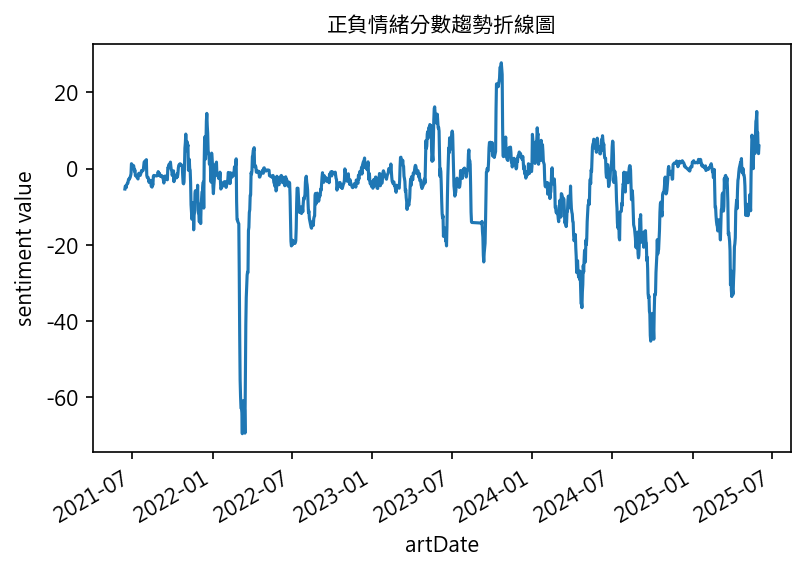

In [359]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment Ë®àÁÆóÊñπÂºè: positive - negative
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["negative"]
)

plt.rcParams["axes.unicode_minus"] = False
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("Ê≠£Ë≤†ÊÉÖÁ∑íÂàÜÊï∏Ë∂®Âã¢ÊäòÁ∑öÂúñ", fontproperties=fprop)

ÂèØ‰ª•ÊòéÈ°ØÁúãÂà∞Ôºö<br>
2022 Âπ¥‰∏≠Âá∫ÁèæÊ∑±Â∫¶‰ΩéË∞∑Ôºà-60 Â∑¶Âè≥ÔºâÔºåÂèØËÉΩÁÇ∫Ê†∏ÁÅΩ„ÄÅÁº∫Èõª„ÄÅÊ†∏ÂõõÁà≠Ë≠∞Á≠â‰∫ã‰ª∂ÁàÜÁôº„ÄÇ<br>
ÂÖ∂‰ªñÂπæÂÄãË≤†Èù¢Ë∞∑Â∫ïÂàÜÂà•Âú® 2023-06„ÄÅ2024-07„ÄÅ2025-01„ÄÇ<br>
2025 Âπ¥‰∏≠ÂæåÂø´ÈÄüÊãâÂçáËá≥Ê≠£ÂÄºÂçÄÈñìÔºåÈ°ØÁ§∫ËøëÊúüÊï¥È´îÊÉÖÁ∑íÂá∫ÁèæÁøªËΩâÊàñÂ§ßÈáèÊ≠£Èù¢ÊñáÁ´†ÊπßÂÖ•„ÄÇ


## ÊñáÁ´†ÁÇ∫ÂñÆ‰ΩçÁöÑÊÉÖÁ∑íÂàÜÊûê

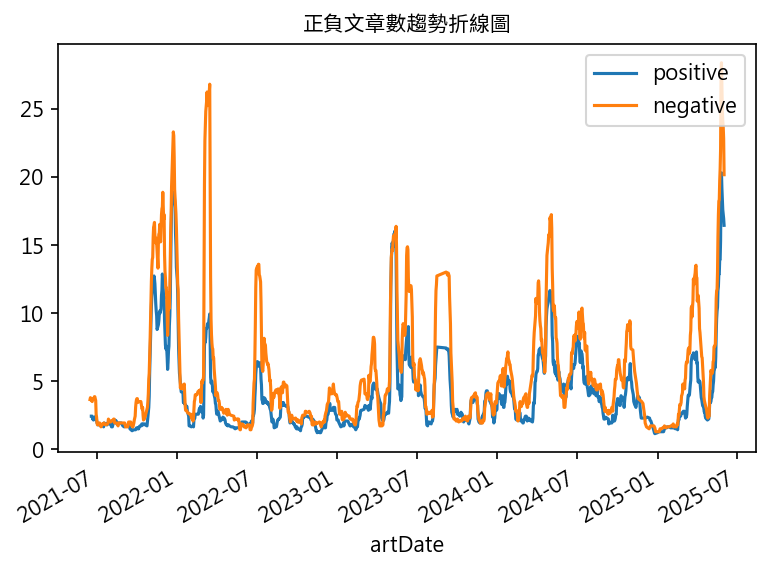

In [360]:
sentiment_count_by_article = pd.DataFrame(
    ptt_liwc_df.groupby(["artUrl", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})

ptt_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="artUrl", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment Ë®àÁÆóÊñπÂºè: positive - negative
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)

ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "Ê≠£Âêë" if x > 0 else "Ë≤†Âêë" )

clear_df_sentiment = pd.merge(df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
clear_df_sentiment["artDate"] = pd.to_datetime(clear_df_sentiment["artDate"])
clear_df_sentiment['artDate'] = clear_df_sentiment['artDate'].dt.date

sentiment_art_count = pd.DataFrame(
    clear_df_sentiment.groupby(["artDate", "sentiment_class"]).size()
).reset_index()
sentiment_art_count = sentiment_art_count.rename(columns={0: "size"})
sentiment_art_count = sentiment_art_count.sort_values(["artDate"])

colors = ["tab:blue", "tab:orange"]
pos = sentiment_art_count[sentiment_art_count["sentiment_class"] == "Ê≠£Âêë"]
neg = sentiment_art_count[sentiment_art_count["sentiment_class"] == "Ë≤†Âêë"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # ‰πüÂèØ‰ª•Âú®Ë©≤ÂúñË®≠ÂÆöÂèÉÊï∏
fig, ax = plt.subplots()

# ‰ΩøÁî® Series.rolling().mean() ‰æÜÁî¢Áîü 14 Â§©Âπ≥Âùá
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])
# ax.plot(pos["artDate"], pos['size'], color=colors[0])
# ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("Ê≠£Ë≤†ÊñáÁ´†Êï∏Ë∂®Âã¢ÊäòÁ∑öÂúñ", fontproperties=fprop)  # Ë®òÂæóÂä†‰∏äÊâçËÉΩÈ°ØÁ§∫‰∏≠Êñá
plt.show()

ÂèØ‰ª•ËßÄÂØüÂà∞Ôºö<br>
2022Âπ¥ÂàùÔΩû‰∏≠ÔºöË≤†Èù¢ÊñáÁ´†Êï∏È°ØËëóÈ´òÔºåÊ≠£Èù¢ÊñáÁ´†‰πüÊúâÂ∞èÊ≥¢ÂãïÔºå‰ΩÜËºÉÂ∞ë„ÄÇ<br>
2023 Âπ¥ÂæåÔºöÊ≠£Ë≤†Êï∏ÈáèË∂®ÊñºÊé•ËøëÔºåÂ∞§ÂÖ∂Âú®Êüê‰∫õÈ´òÂ≥∞ÊúüÔºàÂ¶Ç2024-01„ÄÅ2025-06ÔºâÂπæ‰πéÈáçÁñä„ÄÇ<br>
2025Âπ¥‰∏≠ÔºöÊ≠£Èù¢ÊñáÁ´†Á™ÅÁÑ∂Â§ßÈáèÂ¢ûÂä†ÔºåËàáÂâçÂºµÂúñË∂®Âã¢‰∏ÄËá¥ÔºåÈ°ØÁ§∫ËøëÊúüÊòéÈ°ØËΩâÂêëÊ≠£ÂêëÊÉÖÁ∑í„ÄÇ

## ÊÉÖÁ∑í‰ª£Ë°®Â≠ó

C:\Users\rolya\AppData\Local\Temp\ipykernel_10104\2728981295.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
C:\Users\rolya\AppData\Local\Temp\ipykernel_10104\2728981295.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, 'Ë≤†ÂêëÊÉÖÁ∑íÁ∏ΩÊï∏')

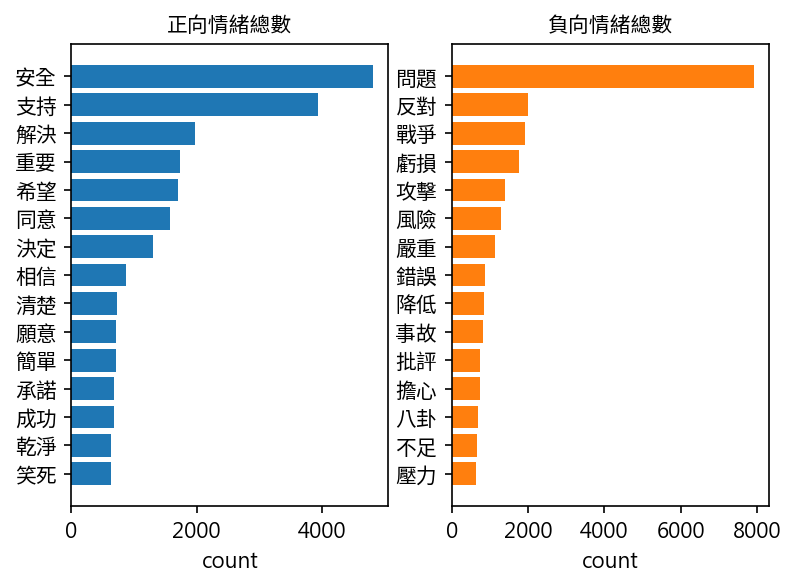

In [361]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)

word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]

pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("Ê≠£ÂêëÊÉÖÁ∑íÁ∏ΩÊï∏", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("Ë≤†ÂêëÊÉÖÁ∑íÁ∏ΩÊï∏", fontproperties=fprop)

### Ê™¢Êü•ÊÉÖÁ∑íË©ûÊòØÂê¶Á¨¶ÂêàÊú¨ÊñáÊú¨

In [371]:
filtered_df = sent_df[sent_df['sentence'].str.contains('ÊëßÊØÄ', na=False)]

for sentence in filtered_df['sentence'].to_list():
    print(sentence)
    print("=========================")

Áü≥ÂåñÁáÉÊñôÊ≠£Âú®ÊëßÊØÄÂú∞ÁêÉ
Êé•ËëóÊëßÊØÄÊâÄÊúâÊµ∑‰∏äÈ¢®ÂäõÁôºÈõªË®≠ÊñΩÁöÑÊôÇÂÄôÊÄéÈ∫ºËæ¶
‰ªäÂ§©ÊòØÊëßÊØÄËóªÁ§Å
Ë¢´ÊëßÊØÄÁöÑÂüéÂ∏ÇÊòØÈù¢ÁöÑÁÅΩÂÆ≥
ËªäË´æÊØîÊ†∏ÈõªÂª†ÊóÅÈñãÁÅ´„ÄÄÊ†∏Âª¢ÊñôË®≠ÊñΩÈÅ≠ÊëßÊØÄ
‰∏ÄÊ†∏Âª¢ÊñôÂÑ≤Â≠òË®≠ÊñΩÈÅ≠Âà∞ÊëßÊØÄ
Â¶ÇÊûúÊ†∏Âª¢ÊñôÂÑ≤Â≠òË®≠ÊñΩÂõ†Á†≤ÊìäË¢´ÊëßÊØÄ
ÁõÆÂâçÂ∞öÁÑ°Ê≥ïÂæóÁü•Ê†∏Âª¢ÊñôË®≠ÊñΩË¢´ÊëßÊØÄÊòØÂê¶ÊúâÈÄ†ÊàêËºªÂ∞ÑÊ±°ÊüìÁöÑÁãÄÊ≥Å
Êõ¥Áõ¥Ë®ÄËé´ÊñØÁßëÊÉ≥ËóâÁî±ÊëßÊØÄÂúãÂÆ∂ÂÖÉÈ¶ñ‰æÜÂæûÊîøÊ≤ª‰∏äÊìäÊïóÁÉèÂÖãËò≠
‰ªñÂÄëÊÉ≥ÈÄèÈÅéÊëßÊØÄÂúãÂÆ∂ÂÖÉÈ¶ñ
ÁÉèÂÖãËò≠ËªçÊñπÁ®±Êúâ40Ëºõ‰øÑËªçË£ùÁî≤ËªäÂú®ÁßëË´æÊâòÊôÆ Konotop Âú∞ÂçÄË¢´ÊëßÊØÄ
ÁÑ°Ë´ñÁôΩÂ§©Â§úÊôöÈÉΩÊúÉÂæàÂç±Èö™Á†¥Â£ûÁµÑÁπîÊ≠£Âú®ÊëßÊØÄÂü∫ËºîÁöÑËªç‰∫ãÂíåÂü∑Ê≥ïÊ©üÊßã
ÊëßÊØÄÁÉèËªç67ËºõÂù¶ÂÖãÂíåÂÖ∂‰ªñË£ùÁî≤Êà∞Ëªä16ÁµÑÂ§öÁÆ°ÁÅ´ÁÆ≠Á†≤87ËºõÁâπÁ®ÆËªçÁî®Ëªä
ÊëßÊØÄ‰∫Ü‰øÑËªç80ËºõÂù¶ÂÖã500Â§öËºõËªçÁî®Ëªä10Êû∂Êà∞Ê©üÂíå7Êû∂Áõ¥ÂçáÊ©ü
Âè∞Èõª‰∏ÄÂÜçÁôºÁîü‰∏Ä‰∫∫ÊëßÊØÄÂÖ®Âè∞ÈõªÂäõ‰∫ã‰ª∂
‰∏ÄÂÜçÁôºÁîü‰∏Ä‰∫∫ÊëßÊØÄÂÖ®Âè∞ÈõªÂäõ‰∫ã‰ª∂
Â∑≤ÊëßÊØÄ251Ëºõ‰øÑÁæÖÊñØÊà∞Ëªä939ËºõË£ùÁî≤ÈÅãÂÖµËªä
‰øÑÁæÖÊñØËªçÈöäÂú®ÁÉèÂÖãËò≠Á¨¨‰∫åÂ§ßÂüéÂ∏ÇÊëßÊØÄ‰∫Ü‰

### ÈáçÊñ∞Ë®àÁÆóÊÉÖÁ∑í<br>
ÊãøÊéâ‰∏çÁ¨¶ÂêàÊñáÊú¨‰πãÔºö"Êà∞Áà≠", "ÊîªÊìä", "Á¨ëÊ≠ª", "ÂÖ´Âç¶", "ÂíåÂπ≥","Ëá™Áî±", "ÂÖ•‰æµ"

In [460]:
# Ë®≠ÂÆöË¶ÅÁßªÈô§ÁöÑÂ≠óË©ûÂàóË°®
words_to_remove = ["Êà∞Áà≠", "ÊîªÊìä", "Á¨ëÊ≠ª", "ÂÖ´Âç¶", "ÂíåÂπ≥","Ëá™Áî±", "ÂÖ•‰æµ"]
# ‰ΩøÁî® ~ ÈÅãÁÆóÂ≠êÂíå isin() ÊñπÊ≥ïÈÅéÊøæÊéâÂåÖÂê´Âú® words_to_remove ÂàóË°®‰∏≠ÁöÑË°å
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
# ‰ΩøÁî®Êõ¥Êñ∞ÂæåÁöÑÊÉÖÁ∑íÂ≠óÂÖ∏ merge
ptt_liwc_df_revise = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent","word"]], liwc_dict_revise, how="left")
ptt_liwc_df_revise.head()

artUrl     artDate  \
0  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  2021-06-01   
1  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  2021-06-01   
2  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  2021-06-01   
3  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  2021-06-01   
4  https://www.ptt.cc/bbs/HatePolitics/M.16224802...  2021-06-01   

                  artTitle                                         artContent  \
0  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...   
1  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...   
2  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...   
3  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...   
4  [Ë®éË´ñ]ÊîøÂ∫úÁõ¥Êé•Ë∑ü‰∏äÊµ∑Âæ©ÊòüË≤∑Â∞±Ê≤íÈÄôÈ∫ºÂ§öÂïèÈ°åÂêßÔºü  Â§ßÂÆ∂ÂÆâÂÆâ\n\nËÄÅÂØ¶Ë™™Ê∞ëÈÄ≤Èª®ÊîøÂ∫ú‰∏çÁü•ÈÅìÁÇ∫‰ΩïÂ∏∏Â∏∏Â†ÖÊåÅ‰∏ÄÂ†ÜÂ•áÊÄ™ÁöÑÈªû\n\n20ÂπæÂπ¥Ê≠∑Âè≤ÁöÑÊ†∏ÈõªÂ∞±ÁÆó...   

  word sentiments  
0   ÂÆâÂÆâ        NaN  
1  ËÄÅÂØ¶Ë™™        NaN  
2  Ê∞ëÈÄ≤Èª®        NaN  
3   ÊîøÂ∫ú        NaN  
4   Áü•ÈÅì        NaN

C:\Users\rolya\AppData\Local\Temp\ipykernel_10104\2708770589.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
C:\Users\rolya\AppData\Local\Temp\ipykernel_10104\2708770589.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, 'Ë≤†ÂêëÊÉÖÁ∑íÁ∏ΩÊï∏')

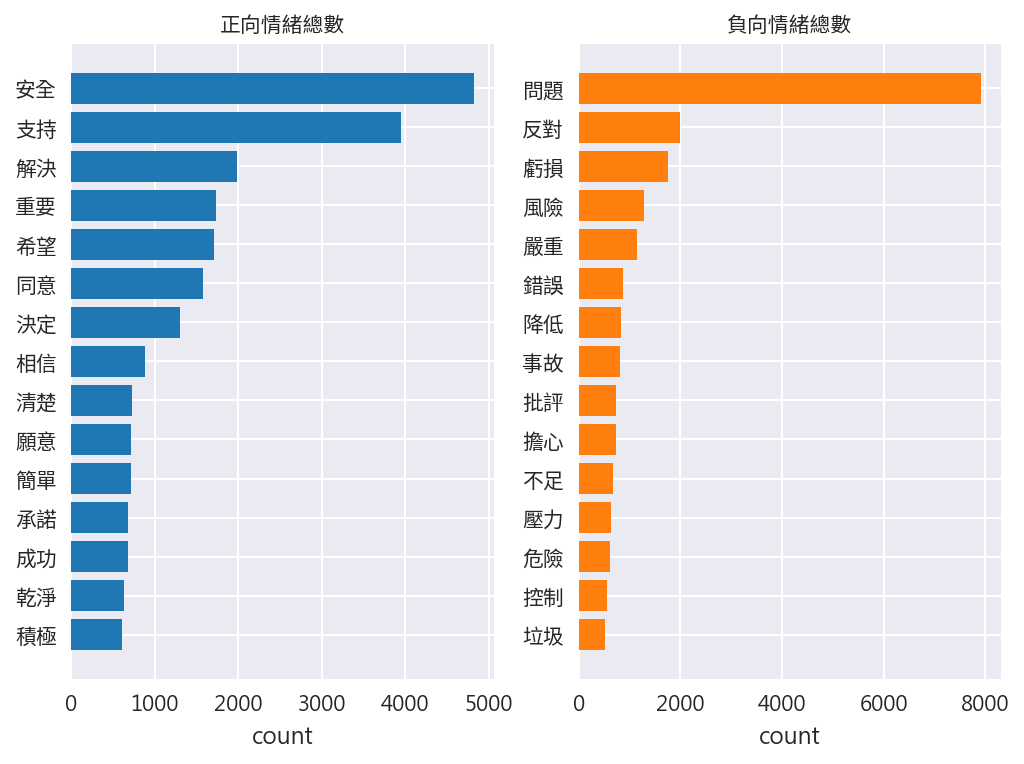

In [462]:
word_count = ptt_liwc_df_revise.groupby(["word", "sentiments"]).size().reset_index()

word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)

word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]

pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("Ê≠£ÂêëÊÉÖÁ∑íÁ∏ΩÊï∏", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("Ë≤†ÂêëÊÉÖÁ∑íÁ∏ΩÊï∏", fontproperties=fprop)

### ÈáçÊñ∞Áπ™Ë£ΩÊÉÖÁ∑íÂàÜÊï∏Ë∂®Âã¢Âúñ

Text(0.5, 1.0, 'Ê≠£Ë≤†ÊÉÖÁ∑íÂàÜÊï∏Ë∂®Âã¢ÊäòÁ∑öÂúñ')

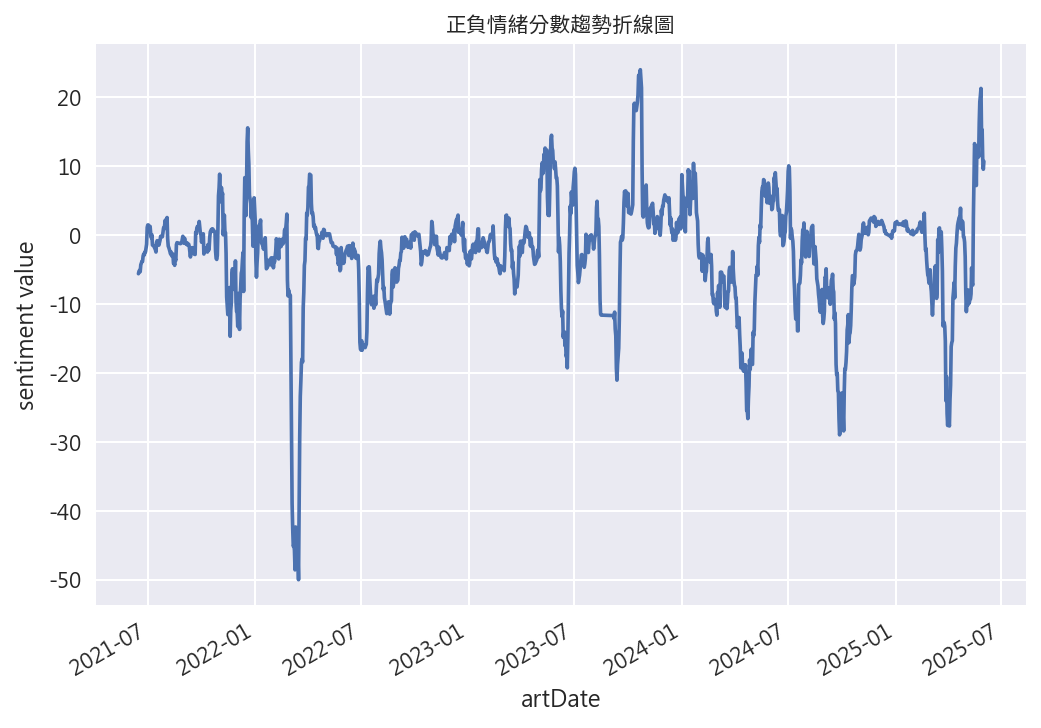

In [463]:
sentiment_count_revise = pd.DataFrame(
    ptt_liwc_df_revise.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count_revise['sentiments'] == "positive") | (sentiment_count_revise['sentiments'] == "negative") 
sentiment_count_revise = sentiment_count_revise.loc[mask]

sentiment_count_revise = sentiment_count_revise.rename(columns={0: "size"})
sentiment_count_revise = sentiment_count_revise.sort_values(["artDate"])

ptt_sentiment_value_revise = (
    sentiment_count_revise.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment Ë®àÁÆóÊñπÂºè: positive - negative
ptt_sentiment_value_revise["sentiment_value"] = (
    ptt_sentiment_value_revise["positive"]
    - ptt_sentiment_value_revise["negative"]
)

# Áπ™Ë£ΩÊÉÖÁ∑íÂàÜÊï∏Ë∂®Âã¢Âúñ
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value_revise["artDate"], ptt_sentiment_value_revise["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("Ê≠£Ë≤†ÊÉÖÁ∑íÂàÜÊï∏Ë∂®Âã¢ÊäòÁ∑öÂúñ", fontproperties=fprop)

ÈáçÊñ∞ËßÄÂØüÔºö<br>
Êï∏ÂÄºËêΩÈªûÊØî‰∏ä‰∏ÄÂºµÊõ¥ÂÅè‰∏≠ÈñìÂçÄÈñìÔºà-50 ÔΩû +20Ôºâ„ÄÇ<br>
Â§öÊï∏ÊôÇÈñìÊÉÖÁ∑íÂÄºÂú® -10ÔΩû+10 ÈñìÊ≥¢ÂãïÔºåÂëàÁèæ ÂèçË¶ÜÊãâÈã∏„ÄÇ<br>
ÊúÄ‰ΩéË∞∑‰ªçÁÑ∂Âá∫ÁèæÂú® 2022 Âπ¥‰∏≠ÔºåËàáÊ†∏ÂÆâÁà≠Ë≠∞È´òÂ∫¶Áõ∏Èóú„ÄÇ<br>
2025 Âπ¥‰∏≠ÊÉÖÁ∑íÂõûÂçáÔºåÊ≠£Èù¢Ë©ïÂÉπ‰ΩîÂÑ™Âã¢ÔºåËàáÊñáÁ´†Êï∏Ë∂®Âã¢Âúñ‰∏ÄËá¥„ÄÇ

## ÊñáÂ≠óÈõ≤

In [383]:
ptt_liwc_df_revise = pd.merge(ptt_liwc_df_revise, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")

sent_df = pd.merge(sent_df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")

date = "2022-01-15"
end_date = "2022-04-15"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "Ë≤†Âêë")

ptt_df_wc = ptt_liwc_df_revise.loc[mask]
ptt_df_wc.head(10)

artUrl     artDate  \
91095  https://www.ptt.cc/bbs/HatePolitics/M.16423935...  2022-01-17   
91096  https://www.ptt.cc/bbs/HatePolitics/M.16423935...  2022-01-17   
91097  https://www.ptt.cc/bbs/HatePolitics/M.16423935...  2022-01-17   
91098  https://www.ptt.cc/bbs/HatePolitics/M.16423935...  2022-01-17   
91099  https://www.ptt.cc/bbs/HatePolitics/M.16423935...  2022-01-17   
91100  https://www.ptt.cc/bbs/HatePolitics/M.16423935...  2022-01-17   
91101  https://www.ptt.cc/bbs/HatePolitics/M.16423935...  2022-01-17   
91102  https://www.ptt.cc/bbs/HatePolitics/M.16423935...  2022-01-17   
91103  https://www.ptt.cc/bbs/HatePolitics/M.16423935...  2022-01-17   
91104  https://www.ptt.cc/bbs/HatePolitics/M.16423935...  2022-01-17   

                       artTitle  \
91095  [Ë®éË´ñ]Á¶èÈ£üVSÊ†∏Âª¢ÊñôËóçÈùíÂπ¥È†òË¢ñÂ∑ßËäØË¶∫ÂæóÂì™Âç±Èö™?   
91096  [Ë®éË´ñ]Á¶èÈ£üVSÊ†∏Âª¢ÊñôËóçÈùíÂπ¥È†òË¢ñÂ∑ßËäØË¶∫ÂæóÂì™Âç±Èö™?   
91097  [Ë®éË´ñ]Á¶èÈ£üVSÊ†∏Âª¢ÊñôËóçÈùíÂπ¥È†òË¢ñÂ∑ßËäØË¶∫ÂæóÂì™Âç±Èö™?   
91098  [Ë®éË´ñ]Á¶èÈ£üVSÊ†∏Âª¢ÊñôËóçÈùíÂπ¥È†òË¢ñÂ∑ßËäØË¶∫ÂæóÂì™Âç±Èö™?   
91099  [Ë®éË´ñ]Á¶èÈ£üVSÊ†∏Âª¢ÊñôËóçÈùíÂπ¥È†òË¢ñÂ∑ßËäØË¶∫ÂæóÂì™Âç±Èö™?   
91100  [Ë®éË´ñ]Á¶èÈ£üVSÊ†∏Âª¢ÊñôËóçÈùíÂπ¥È†òË¢ñÂ∑ßËäØË¶∫ÂæóÂì™Âç±Èö™?   
91101  [Ë®éË´ñ]Á¶èÈ£üVSÊ†∏Âª¢ÊñôËóçÈùíÂπ¥È†òË¢ñÂ∑ßËäØË¶∫ÂæóÂì™Âç±Èö™?   
91102  [Ë®éË´ñ]Á¶èÈ£üVSÊ†∏Âª¢ÊñôËóçÈùíÂπ¥È†òË¢ñÂ∑ßËäØË¶∫ÂæóÂì™Âç±Èö™?   
91103  [Ë®éË´ñ]Á¶èÈ£üVSÊ†∏Âª¢ÊñôËóçÈùíÂπ¥È†òË¢ñÂ∑ßËäØË¶∫ÂæóÂì™Âç±Èö™?   
91104  [Ë®éË´ñ]Á¶èÈ£üVSÊ†∏Âª¢ÊñôËóçÈùíÂπ¥È†òË¢ñÂ∑ßËäØË¶∫ÂæóÂì™Âç±Èö™?   

                                              artContent word sentiments  \
91095  ÂÖ®‰∏ñÁïåÂè™Ââ©‰∏ãÂè∞ÁÅ£Ë∑ü‰∏≠Âúã‰∏çË®±ÈÄ≤Âè£ÁöÑÁ¶èÂ≥∂È£üÁâ©\nË∑üÂè™Ë¶ÅÊúâÊ†∏ÈõªÂª†Â∞±ÊúÉÊúâÁöÑÊ†∏Âª¢Êñô  ‰ΩÜÊòØÂèØ‰ª•Êé•ÂèóÊîæÂÆ∂...  ÂÖ®‰∏ñÁïå        NaN   
91096  ÂÖ®‰∏ñÁïåÂè™Ââ©‰∏ãÂè∞ÁÅ£Ë∑ü‰∏≠Âúã‰∏çË®±ÈÄ≤Âè£ÁöÑÁ¶èÂ≥∂È£üÁâ©\nË∑üÂè™Ë¶ÅÊúâÊ†∏ÈõªÂª†Â∞±ÊúÉÊúâÁöÑÊ†∏Âª¢Êñô  ‰ΩÜÊòØÂèØ‰ª•Êé•ÂèóÊîæÂÆ∂...   Ââ©‰∏ã        NaN   
91097  ÂÖ®‰∏ñÁïåÂè™Ââ©‰∏ãÂè∞ÁÅ£Ë∑ü‰∏≠Âúã‰∏çË®±ÈÄ≤Âè£ÁöÑÁ¶èÂ≥∂È£üÁâ©\nË∑üÂè™Ë¶ÅÊúâÊ†∏ÈõªÂª†Â∞±ÊúÉÊúâÁöÑÊ†∏Âª¢Êñô  ‰ΩÜÊòØÂèØ‰ª•Êé•ÂèóÊîæÂÆ∂...   Âè∞ÁÅ£        NaN   
91098  ÂÖ®‰∏ñÁïåÂè™Ââ©‰∏ãÂè∞ÁÅ£Ë∑ü‰∏≠Âúã‰∏çË®±ÈÄ≤Âè£ÁöÑÁ¶èÂ≥∂È£üÁâ©\nË∑üÂè™Ë¶ÅÊúâÊ†∏ÈõªÂª†Â∞±ÊúÉÊúâÁöÑÊ†∏Âª¢Êñô  ‰ΩÜÊòØÂèØ‰ª•Êé•ÂèóÊîæÂÆ∂...   ‰∏≠Âúã        NaN   
91099  ÂÖ®‰∏ñÁïåÂè™Ââ©‰∏ãÂè∞ÁÅ£Ë∑ü‰∏≠Âúã‰∏çË®±ÈÄ≤Âè£ÁöÑÁ¶èÂ≥∂È£üÁâ©\nË∑üÂè™Ë¶ÅÊúâÊ†∏ÈõªÂª†Â∞±ÊúÉÊúâÁöÑÊ†∏Âª¢Êñô  ‰ΩÜÊòØÂèØ‰ª•Êé•ÂèóÊîæÂÆ∂...   ‰∏çË®±        NaN   
91100  ÂÖ®‰∏ñÁïåÂè™Ââ©‰∏ãÂè∞ÁÅ£Ë∑ü‰∏≠Âúã‰∏çË®±ÈÄ≤Âè£ÁöÑÁ¶èÂ≥∂È£üÁâ©\nË∑üÂè™Ë¶ÅÊúâÊ†∏ÈõªÂª†Â∞±ÊúÉÊúâÁöÑÊ†∏Âª¢Êñô  ‰ΩÜÊòØÂèØ‰ª•Êé•ÂèóÊîæÂÆ∂...   ÈÄ≤Âè£        NaN   
91101  ÂÖ®‰∏ñÁïåÂè™Ââ©‰∏ãÂè∞ÁÅ£Ë∑ü‰∏≠Âúã‰∏çË®±ÈÄ≤Âè£ÁöÑÁ¶èÂ≥∂È£üÁâ©\nË∑üÂè™Ë¶ÅÊúâÊ†∏ÈõªÂª†Â∞±ÊúÉÊúâÁöÑÊ†∏Âª¢Êñô  ‰ΩÜÊòØÂèØ‰ª•Êé•ÂèóÊîæÂÆ∂...   Á¶èÂ≥∂        NaN   
91102  ÂÖ®‰∏ñÁïåÂè™Ââ©‰∏ãÂè∞ÁÅ£Ë∑ü‰∏≠Âúã‰∏çË®±ÈÄ≤Âè£ÁöÑÁ¶èÂ≥∂È£üÁâ©\nË∑üÂè™Ë¶ÅÊúâÊ†∏ÈõªÂª†Â∞±ÊúÉÊúâÁöÑÊ†∏Âª¢Êñô  ‰ΩÜÊòØÂèØ‰ª•Êé•ÂèóÊîæÂÆ∂...   È£üÁâ©        NaN   
91103  ÂÖ®‰∏ñÁïåÂè™Ââ©‰∏ãÂè∞ÁÅ£Ë∑ü‰∏≠Âúã‰∏çË®±ÈÄ≤Âè£ÁöÑÁ¶èÂ≥∂È£üÁâ©\nË∑üÂè™Ë¶ÅÊúâÊ†∏ÈõªÂª†Â∞±ÊúÉÊúâÁöÑÊ†∏Âª¢Êñô  ‰ΩÜÊòØÂèØ‰ª•Êé•ÂèóÊîæÂÆ∂...  Ê†∏ÈõªÂª†        NaN   
91104  ÂÖ®‰∏ñÁïåÂè™Ââ©‰∏ãÂè∞ÁÅ£Ë∑ü‰∏≠Âúã‰∏çË®±ÈÄ≤Âè£ÁöÑÁ¶èÂ≥∂È£üÁâ©\nË∑üÂè™Ë¶ÅÊúâÊ†∏ÈõªÂª†Â∞±ÊúÉÊúâÁöÑÊ†∏Âª¢Êñô  ‰ΩÜÊòØÂèØ‰ª•Êé•ÂèóÊîæÂÆ∂...   Âª¢Êñô        NaN   

      sentiment_class  
91095              Ë≤†Âêë  
91096              Ë≤†Âêë  
91097              Ë≤†Âêë  
91098              Ë≤†Âêë  
91099              Ë≤†Âêë  
91100              Ë≤†Âêë  
91101              Ë≤†Âêë  
91102              Ë≤†Âêë  
91103              Ë≤†Âêë  
91104              Ë≤†Âêë

In [384]:
date = "2022-01-15"
end_date = "2022-04-15"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "Ë≤†Âêë")

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]


word_count_count = pd.DataFrame(
    ptt_df_wc.groupby(["word"]).size()
).reset_index().rename(columns={0: "size"})

word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count.head(10)

word  size
10719  ÁÉèÂÖãËò≠  1000
5309    ÂïèÈ°å   756
9588   Ê†∏ÈõªÂª†   749
4999    Âè∞ÁÅ£   650
3447   ‰øÑÁæÖÊñØ   592
9586    Ê†∏Èõª   466
8851    Êñ∞ËÅû   404
12744   ËÉΩÊ∫ê   377
3451    ‰øÑËªç   364
3589    ÂÅúÈõª   341

(-0.5, 1599.5, 799.5, -0.5)

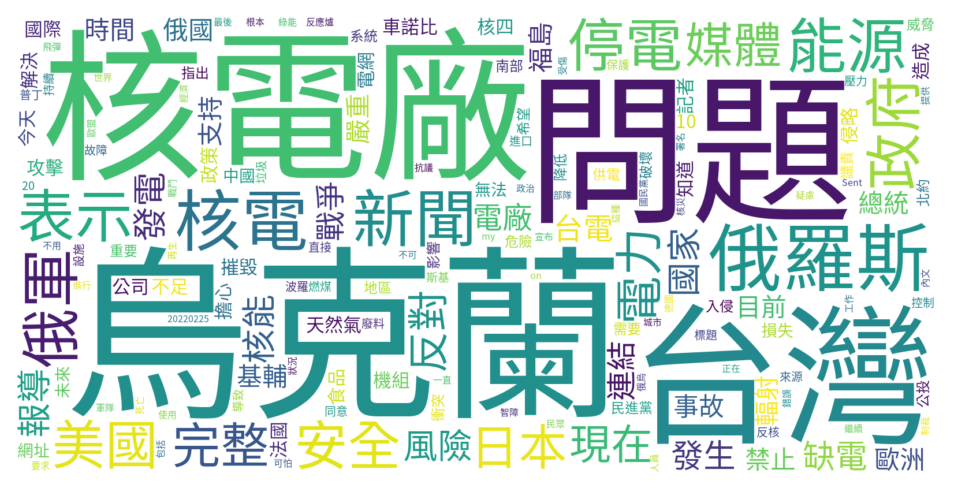

In [386]:
# wordcloud ÁöÑ input ÊòØ dictionary
font_path = "SourceHanSansTW-Regular.otf"  # ‰∏≠ÊñáÂ≠óÂûãË∑ØÂæë
wc_dict = dict(zip(word_count_count['word'], word_count_count['size']))
cloud = WordCloud(scale = 4, max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc_dict)
# Áπ™Âúñ
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

ËßÄÂØüÈáçÈªûÔºö<br>
„ÄåÊ†∏ÈõªÂª†„Äç„ÄåÊ†∏Èõª„Äç„ÄåÁÉèÂÖãËò≠„Äç„ÄåÂè∞ÁÅ£„Äç„ÄåÂïèÈ°å„ÄçÁÇ∫ÊúÄÊ†∏ÂøÉÂ≠óË©ûÔºåÈ°ØÁ§∫ÈÄô‰∫õÊòØË®éË´ñ‰∏ªÈ´î„ÄÇ<br>
Âá∫Áèæ„Äå‰øÑÁæÖÊñØ„Äç„ÄåÁæéÂúã„Äç„ÄåÂ§©ÁÑ∂Ê∞£„Äç„ÄåÂ™íÈ´î„Äç„ÄåÂÅúÈõª„ÄçÁ≠âÂ≠óË©ûÔºåÈ°ØÁ§∫ËàáÂúãÈöõËÉΩÊ∫êÂú∞Á∑£ÊîøÊ≤ªË≠∞È°åÁõ∏Èóú„ÄÇ<br>
ÈóúÈçµÂãïË©ûËàáÊÉÖÁ∑íÈ°ûË©ûÔºöÂ¶Ç„ÄåË°®Á§∫„Äç„ÄåÂÆâÂÖ®„Äç„ÄåÈ¢®Èö™„Äç„ÄåÁôºÁîü„Äç„ÄåÁ¶ÅÊ≠¢„Äç„ÄåÊîØÊåÅ„Äç„ÄåÂç±Èö™„ÄçÂëàÁèæÂ∞çÁ´ãË™ûÂ¢É„ÄÇ<br>

Êé®Ë´ñÔºö<br>
ÈÄôÂºµÂúñÈ°ØÁ§∫Ê†∏ÈõªË≠∞È°åËàáÂúãÈöõÊÉÖÂã¢È´òÂ∫¶ÈÄ£ÁµêÔºàÂ¶Ç‰øÑÁÉèÊà∞Áà≠„ÄÅËÉΩÊ∫êÂç±Ê©üÔºâÔºåÂúãÂÖßÂ§ñÂ™íÈ´îÂ†±Â∞éËàáÊîøÁ≠ñË®éË´ñÊòØË®éË´ñ‰∏ªË¶Å‰æÜÊ∫ê„ÄÇË≤†Èù¢ÈóúÈçµË©ûÂ¶Ç„ÄåÂïèÈ°å„Äç„ÄåÈ¢®Èö™„ÄçËàáÊ≠£Èù¢Â¶Ç„ÄåÂÆâÂÖ®„Äç„ÄåÊîØÊåÅ„Äç‰∏¶Â≠òÔºåÂêªÂêàÂÖàÂâçÂúñË°®‰∏≠„ÄåÊÉÖÁ∑íÈÄêÊº∏Â§öÂÖÉ„ÄçÁöÑËßÄÂØü„ÄÇ

(-0.5, 1599.5, 799.5, -0.5)

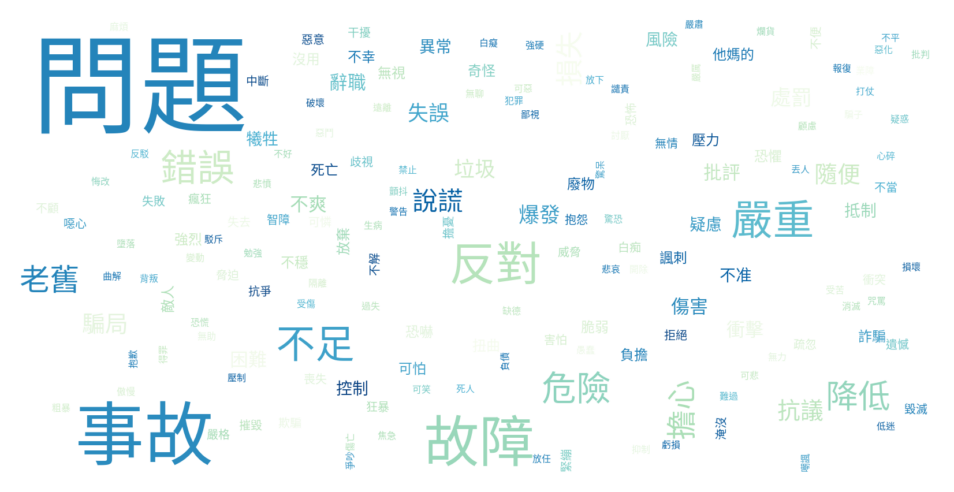

In [388]:
date = "2022-01-15"
end_date = "2022-04-15"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & ( # ÊôÇÈñìÂçÄÈñì
    ptt_liwc_df_revise['sentiment_class'] == "Ë≤†Âêë")  & ( # Ë≤†Èù¢ÊñáÁ´†
    ptt_liwc_df_revise['artContent'].str.contains('ÂÅúÈõª')) & ( # ÂÖßÊñáÂåÖÂê´ÂÅúÈõª
    ptt_liwc_df_revise["sentiments"] == "negative") # Ë≤†Èù¢ÊÉÖÁ∑íÂ≠ó

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

# wordcloud ÁöÑ input ÊòØ dictionary
cloud = WordCloud(scale = 4, max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# Áπ™Âúñ
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

Êé®Ë´ñÔºö<br>
ÈÄôÂºµÂúñÂèçÊò†Âá∫ PTT Ë≤ºÊñáÁöÑË≤†Èù¢Ë™ûË®ÄÂÖ∑ÊúâÂ§öÂ±§Ê¨°‚Äî‚ÄîÂæûÁêÜÊÄßÊâπË©ïÔºàÂ¶ÇÈ¢®Èö™„ÄÅÊïÖÈöúÔºâÂà∞È´òÂ∫¶‰∏ªËßÄÊàñÊÉÖÁ∑íÂåñÔºàÂ¶ÇÂûÉÂúæ„ÄÅ‰∏çÁàΩ„ÄÅË™™Ë¨ä„ÄÅÁàÜÁôºÔºâÔºåÈ°ØÁ§∫Ê†∏ÈõªË≠∞È°åÂú®Á§æÁæ§Âπ≥Âè∞ÂºïÁôºÊÉÖÁ∑íÂåñË®éË´ñËàá„ÄåÈùûÁêÜÊÄßÊÅêÊáº„ÄçÁöÑÂèØËÉΩÊÄß„ÄÇ

In [395]:
date = "2022-01-15"
end_date = "2022-04-15"
mask = (sent_df['artDate'] >= pd.Timestamp(date).date()) & (
    sent_df['artDate'] <= pd.Timestamp(end_date).date()) & (
    sent_df['sentiment_class'] == "Ë≤†Âêë") & (
    sent_df['artContent'].str.contains('ÂÅúÈõª')) & (
    sent_df['sentence'].str.contains('ÂïèÈ°å')) # ÂåÖÂê´„ÄåÂïèÈ°å„ÄçÁöÑÂè•Â≠ê

df_ = sent_df.loc[mask, ["artDate", "artContent", "sentence"]]
index_list = df_.index.tolist()


# ÂèñÂæóÂâçÂæåÂêÑ5Á≠ÜÁöÑÁ¥¢Âºï => ÁõÆÁöÑÁÇ∫Êü•ÁúãÂåÖÂê´Ë©≤Ë©ûÂΩôÂè•Â≠êÁöÑ‰∏ä‰∏ãÊñá
surrounding_indices = []
for index in index_list:
    surrounding_indices.extend(range(index - 5, index + 6))

# ÂéªÈô§ÈáçË§áÁöÑÁ¥¢ÂºïÔºå‰∏¶Á¢∫‰øù‰∏çË∂ÖÂá∫ÁØÑÂúç
surrounding_indices = list(set(filter(lambda x: x >= 0 and x < len(sent_df), surrounding_indices)))

# ‰æùÊìöÁ¥¢ÂºïÂèñÂæóÁõ∏ÊáâÁöÑË≥áÊñô
result_df = sent_df.iloc[surrounding_indices].sort_index()
result_df[['artTitle', 'sentence', 'sentiment_class']]

artTitle               sentence sentiment_class
21061    [ÈªëÁâπ]Êñ∑ÈõªË∑üÈáçÂïüÊ†∏ÂõõÊúâÈóú‰øÇÂóéÔºü                  Â§ßÂÆ∂ÈÉΩÁü•ÈÅì              Ê≠£Âêë
21062    [ÈªëÁâπ]Êñ∑ÈõªË∑üÈáçÂïüÊ†∏ÂõõÊúâÈóú‰øÇÂóéÔºü          Ë¶ÅÊòØÂæàÂÆâÂÖ®ÂèØÈù†Ëß£ÈñãÈÄôÂÄãÂõ∞Â¢É              Ê≠£Âêë
21063    [ÈªëÁâπ]Êñ∑ÈõªË∑üÈáçÂïüÊ†∏ÂõõÊúâÈóú‰øÇÂóéÔºü                  ÊàëÁöÑÊÑèË¶ãÊòØ              Ê≠£Âêë
21064    [ÈªëÁâπ]Êñ∑ÈõªË∑üÈáçÂïüÊ†∏ÂõõÊúâÈóú‰øÇÂóéÔºü                  ‰∏çÂ¶ÇËìãÊ†∏‰∫î              Ê≠£Âêë
21065   [Ë®éË´ñ]ÂÅúÈõªÂ∞±ÊâØÂÖ¨ÊäïÊâçÊòØËº∏‰∏çËµ∑ÂêßÔºü                 ÂÖ¨ÊäïÊòØÂèçÊ†∏Èõª              Ë≤†Âêë
...                   ...                    ...             ...
163591  [ÂïèÂç¶]Ê≠ªÂø†ÁöÑÂÖ∂ÂØ¶ÊâçÊòØÂÑ™Ë≥™ÈÅ∏Ê∞ëÂêß?  Â∞±Êè∂ÊèÑ‰∫Ü‰ªñÂçóÈÉ®Áï¢Á´üÊòØÊ≠ªÂø†ÁöÑÊâçÊúÉÈÄôÊ®£ÂÅúÊ∞¥ÂÅúÈõª              Ë≤†Âêë
163592  [ÂïèÂç¶]Ê≠ªÂø†ÁöÑÂÖ∂ÂØ¶ÊâçÊòØÂÑ™Ë≥™ÈÅ∏Ê∞ëÂêß?        ÈÄôÊôÇËÇ•ËÇ•ÂêåÂ≠∏ÊÖãÂ∫¶Á™ÅÁÑ∂ËÆäÂæóÂæàÂö¥ËÇÖ              Ë≤†Âêë
163593  [ÂïèÂç¶]Ê≠ªÂø†ÁöÑÂÖ∂ÂØ¶ÊâçÊòØÂÑ™Ë≥™ÈÅ∏Ê∞ëÂêß?               Ë™ûÈáçÂøÉÈï∑ÁöÑÂ∞çÊàëË™™              Ë≤†Âêë
163594  [ÂïèÂç¶]Ê≠ªÂø†ÁöÑÂÖ∂ÂØ¶ÊâçÊòØÂÑ™Ë≥™ÈÅ∏Ê∞ëÂêß?              ÂÖ∂ÂØ¶ÊàëÂÄëÂçóÈÉ®Ê≠ªÂø†ÁöÑ              Ë≤†Âêë
163595  [ÂïèÂç¶]Ê≠ªÂø†ÁöÑÂÖ∂ÂØ¶ÊâçÊòØÂÑ™Ë≥™ÈÅ∏Ê∞ëÂêß?             ÊâçË©≤ÊòØÈÅ∏Ê∞ëÁöÑÁêÜÊÉ≥ÂûãÊÖã              Ë≤†Âêë

[1230 rows x 3 columns]

Ë©ï‰º∞Ôºö<br>
Êï¥È´îÂàÜÈ°ûÈÇèËºØÂ∞öÂèØÊé•ÂèóÔºåÂè•Â≠ê‰∏≠Ëã•Âá∫ÁèæÂ¶Ç„ÄåÂÆâÂÖ®„ÄÅËß£Ê±∫„ÄÅÊîØÊåÅ„ÄçÂÇæÂêëË¢´Ê≠∏È°ûÁÇ∫Ê≠£ÂêëÔºõ<br>
ËÄå„ÄåÂèçÊ†∏„ÄÅÂÖ¨ÊäïÂèçÂ∞ç„ÄÅÊ≠ªÂø†„ÄÅÂÅúÈõª„ÄÅÂª¢Áâ©„ÄçÁ≠âË™ûË©ûË™ûÂ¢ÉÂÅèÊâπÂà§ÊÄßÔºåÊúÉË¢´Ê≠∏ÁÇ∫Ë≤†Âêë„ÄÇ

# ‰ΩøÁî®CKIPÈÄ≤Ë°åÊÉÖÁ∑íÂàÜÊûê

In [396]:
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

c:\Users\rolya\anaconda3\envs\Syllabus\Lib\site-packages\ckiptagger\model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\rolya\anaconda3\envs\Syllabus\Lib\site-packages\ckiptagger\model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\rolya\anaconda3\envs\Syllabus\Lib\site-packages\ckiptagger\model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.n

## CKIP Ê®ôË®ª
### Áî®CKIPÈÄ≤Ë°åËôïÁêÜ

In [401]:
def Segmentation_Core(data, tokenizer):
    regexPattern = '|'.join(map(re.escape, tokenizer))
    out = re.split(regexPattern, data)
    return list(filter(None, out))          # ÂéªÊéâÁ©∫ÁôΩË°å


def Sentence_Segmentation(article,
                          keep_digits=False,
                          keep_alphabets=False):
    """
    Â∞áÊñáÁ´†‰æùÂàÜËôü„ÄÅÂè•Ëôü„ÄÅÈ©öÂòÜËôü„ÄÅÂïèËôü‚Ä¶Á≠âÊñ∑Âè•Ôºå‰∏¶Ê∏ÖÊéâÁâπÊÆäÁ¨¶Ëôü„ÄÇ
    * Â∑≤Âä†ÂÖ•Èò≤ÂëÜÔºöËã• article ‰∏çÊòØÂ≠ó‰∏≤ÊàñÁÇ∫ NaNÔºåÁõ¥Êé•Ë¶ñÁÇ∫Á©∫Â≠ó‰∏≤„ÄÇ
    """
    # ----------- ‚ë† Èò≤ÂëÜËôïÁêÜ -----------
    if not isinstance(article, str):
        article = ""                         # Â∞á NaN / float ËΩâÁ©∫Â≠ó‰∏≤

    # ----------- ‚ë° Ê≠£ÂâáÂèÉÊï∏ -----------
    sepical_symbols = r"""[.ÔºÇ<>:„Ää„Äã+\-=#$%&()*@ÔºÉÔºÑÔºÖÔºÜÔºá\(\)\[\]\{\}ÔºàÔºâÔºäÔºãÔºçÔºèÔºö\
ÔºúÔºùÔºûÔº†ÔºªÔººÔºΩÔºæÔºøÔΩÄÔΩõÔΩúÔΩùÔΩûÔΩüÔΩ†ÔΩ¢ÔΩ£ÔΩ§„ÄÅ„ÄÉ„Äã„Äå„Äç„Äé„Äè„Äê„Äë„Äî„Äï„Äñ„Äó„Äò„Äô„Äö„Äõ„Äú„Äù„Äû„Äü„Ä∞„Äæ„Äø‚Äì‚Äî‰∏Ä‚Äò‚Äô‚Äõ‚Äú‚Äù‚Äû‚Äü‚Ä¶‚ÄßÔπè‚òÖ‚Üí‚îÄ]+"""
    segmentation_used_note = (";", "Ôºõ", "ÔºÅ", "!", "Ôºü", "?", "„ÄÇ")

    # ----------- ‚ë¢ ÊñáÁ´†ÂÖàÊåâÊèõË°åÁ¨¶ÂàáÊÆµ -----------
    paragraphs = [p for p in article.split("\n")
                  if re.sub(r"\s+", "", p)]      # ÂéªÊéâÁ¥îÁ©∫ÁôΩË°å

    result = []
    for paragraph in paragraphs:
        clean = paragraph

        # ÁßªÈô§Êï∏Â≠ó / Ëã±Êñá
        if not keep_digits:
            clean = re.sub(r"\d*\.?\d+", "", clean)
        if not keep_alphabets:
            clean = re.sub(r"[a-zA-Z]+", "", clean)

        # ÁßªÈô§Â§öÁ©∫ÁôΩËàáÁâπÊÆäÁ¨¶Ëôü
        clean = re.sub(r"\s+", "", clean)
        clean = re.sub(sepical_symbols, "", clean)

        # Êñ∑Âè•
        sent_list = Segmentation_Core(clean, segmentation_used_note)
        result.append(sent_list)

    return result

In [402]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
    # print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id, word, pos]) 
    # print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
    # print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3], entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    # ÈÅçÊ≠∑ dataframe ÁöÑÊØèÁ≠ÜË≥áÊñô
    for index, row in data_df.iterrows(): # document level    
    # print(f"\ndocument {index}") 

        # Ë≥áÊñôÊ∏ÖÁêÜ ÔºÜ Êñ∑Âè•
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list)
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        # ÈÅçÊ≠∑Ë©≤ document ‰∏≠ÁöÑÊØè‰∏ÄÂÄãÂè•Â≠ê
        for i, sentence in enumerate(flat_list):
            # print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'], sentence])            
            temp_tokens = get_pos(row['system_id'], word_sentence_list[i], pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'], entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [403]:
pos_table, entity_table, sentence_table = get_nlp_result(df)

time costing: 7990.67490029335


In [406]:
# Â∞áÊñáÁ´†Â≠òÊàêcsv
pos_table.to_csv('pos_table_Nu.csv', index = False)
entity_table.to_csv('entity_table_Nu.csv', index = False)
sentence_table.to_csv('sentence_table_Nu.csv', index = False)

## Êé¢Á¥¢ÂàÜÊûê - NER

Text(0.5, 0, 'Frequency')

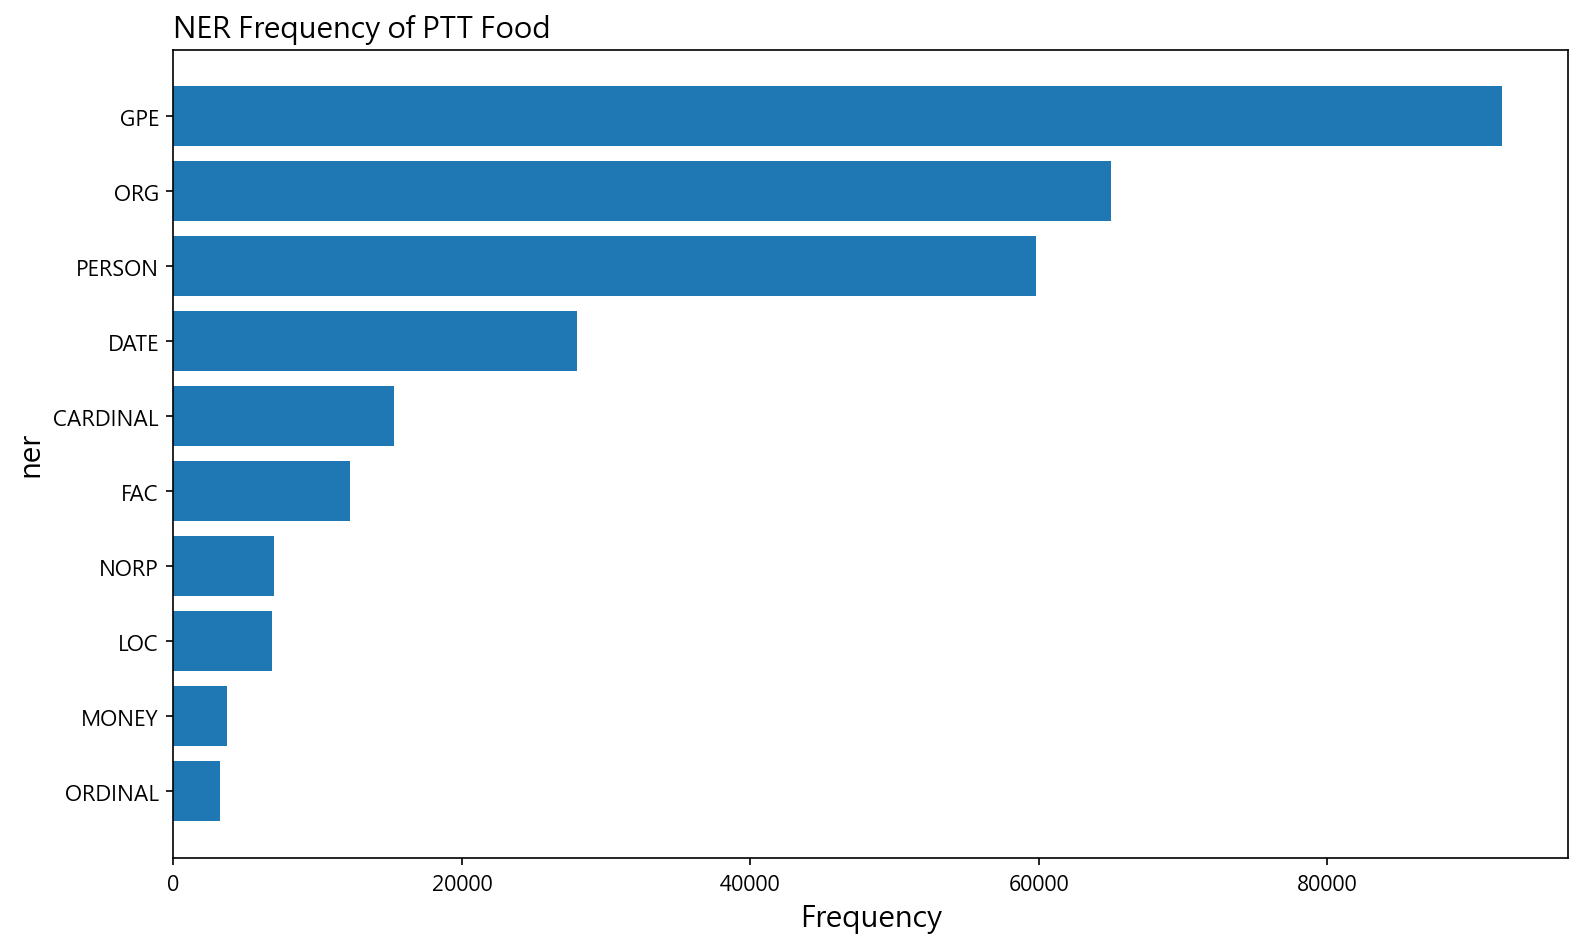

In [408]:
pos_table = pd.read_csv("pos_table_Nu.csv") 
entity_table = pd.read_csv("entity_table_Nu.csv") 
sentence_table = pd.read_csv("sentence_table_Nu.csv") 

ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)

ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of PTT Food',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
# fig.show()

Text(0.5, 0, 'Word Frequency')

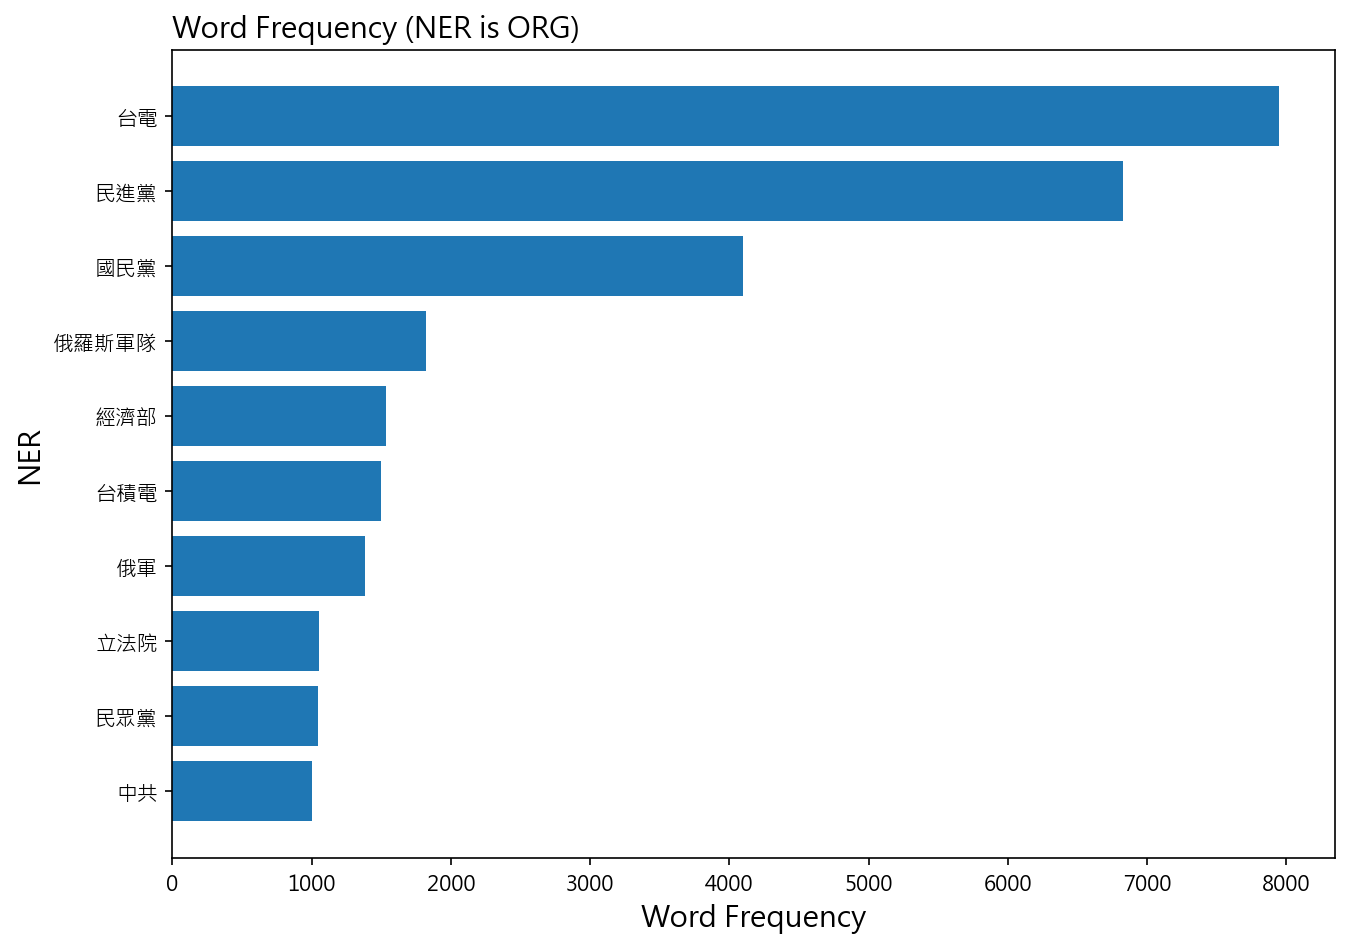

In [414]:
# ÁØ©ÈÅ∏nerÁÇ∫ORGÁöÑË≥áÊñô
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # Ë®àÁÆóÊØèÂÄãÂêçË©ûÊèêÂà∞ÁöÑÊ¨°Êï∏ÔºåÈÅ∏Âá∫Ââç10ÂÄã
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# Ë®≠ÂÆö‰∏≠ÊñáÂ≠óÂΩ¢
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
# fig.show()

Text(0.5, 0, 'Word Frequency')

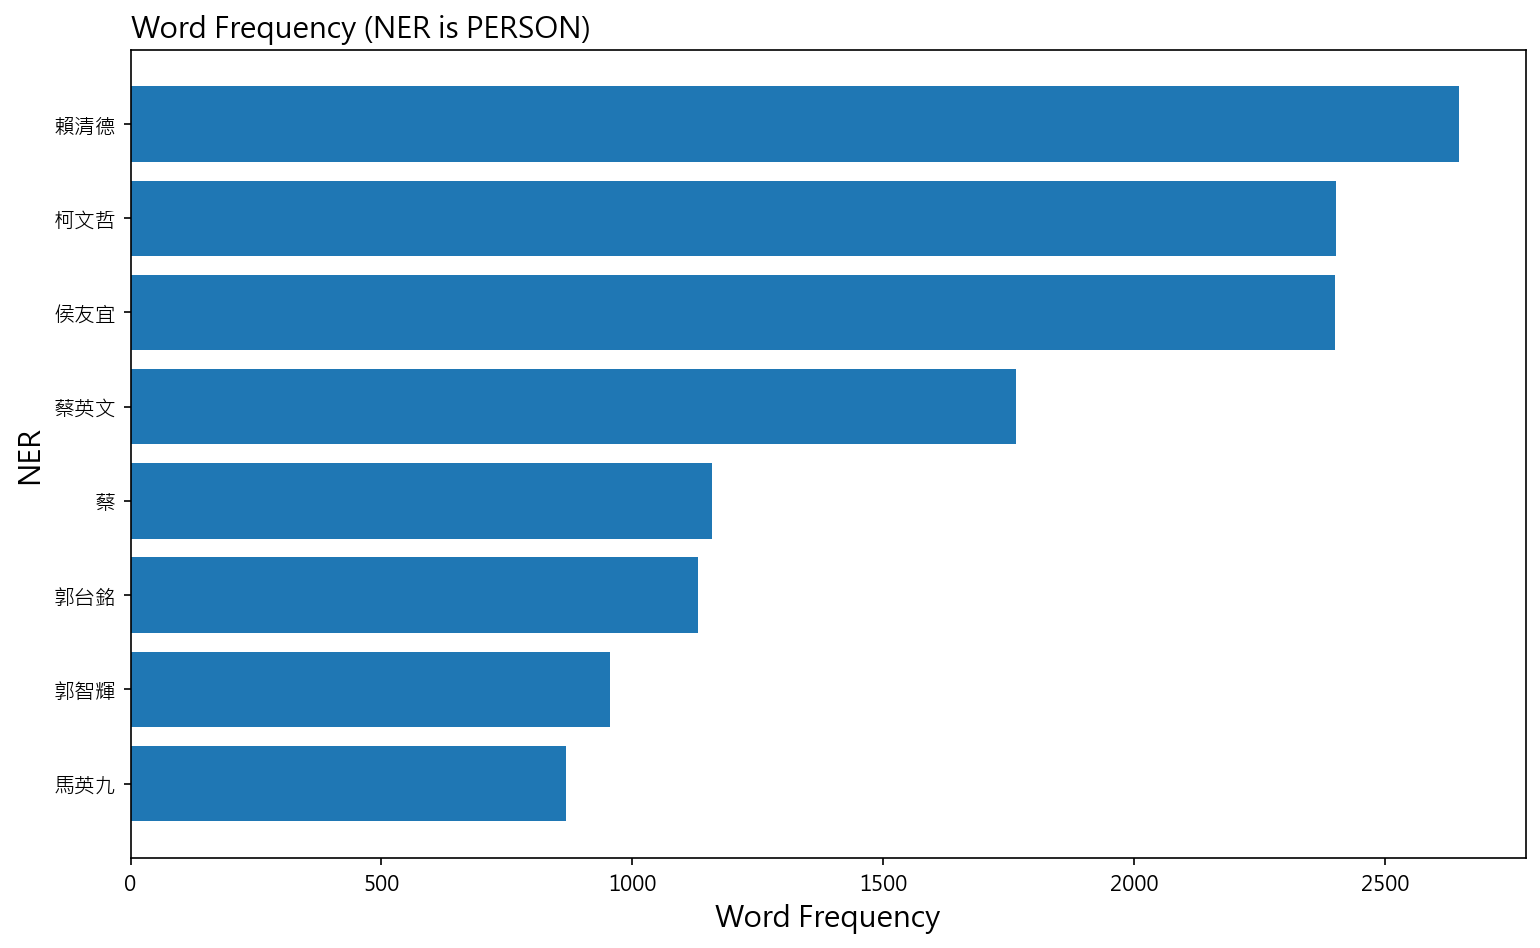

In [415]:
# ÁØ©ÈÅ∏nerÁÇ∫PERSONÁöÑË≥áÊñô
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# Ë®àÁÆóÊØèÂÄãÂêçË©ûÊèêÂà∞ÁöÑÊ¨°Êï∏ÔºåÈÅ∏Âá∫Ââç8ÂÄã
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(8).reset_index()

# Ë®≠ÂÆö‰∏≠ÊñáÂ≠óÂΩ¢
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
# fig.show()

Text(0.5, 0, 'Word Frequency')

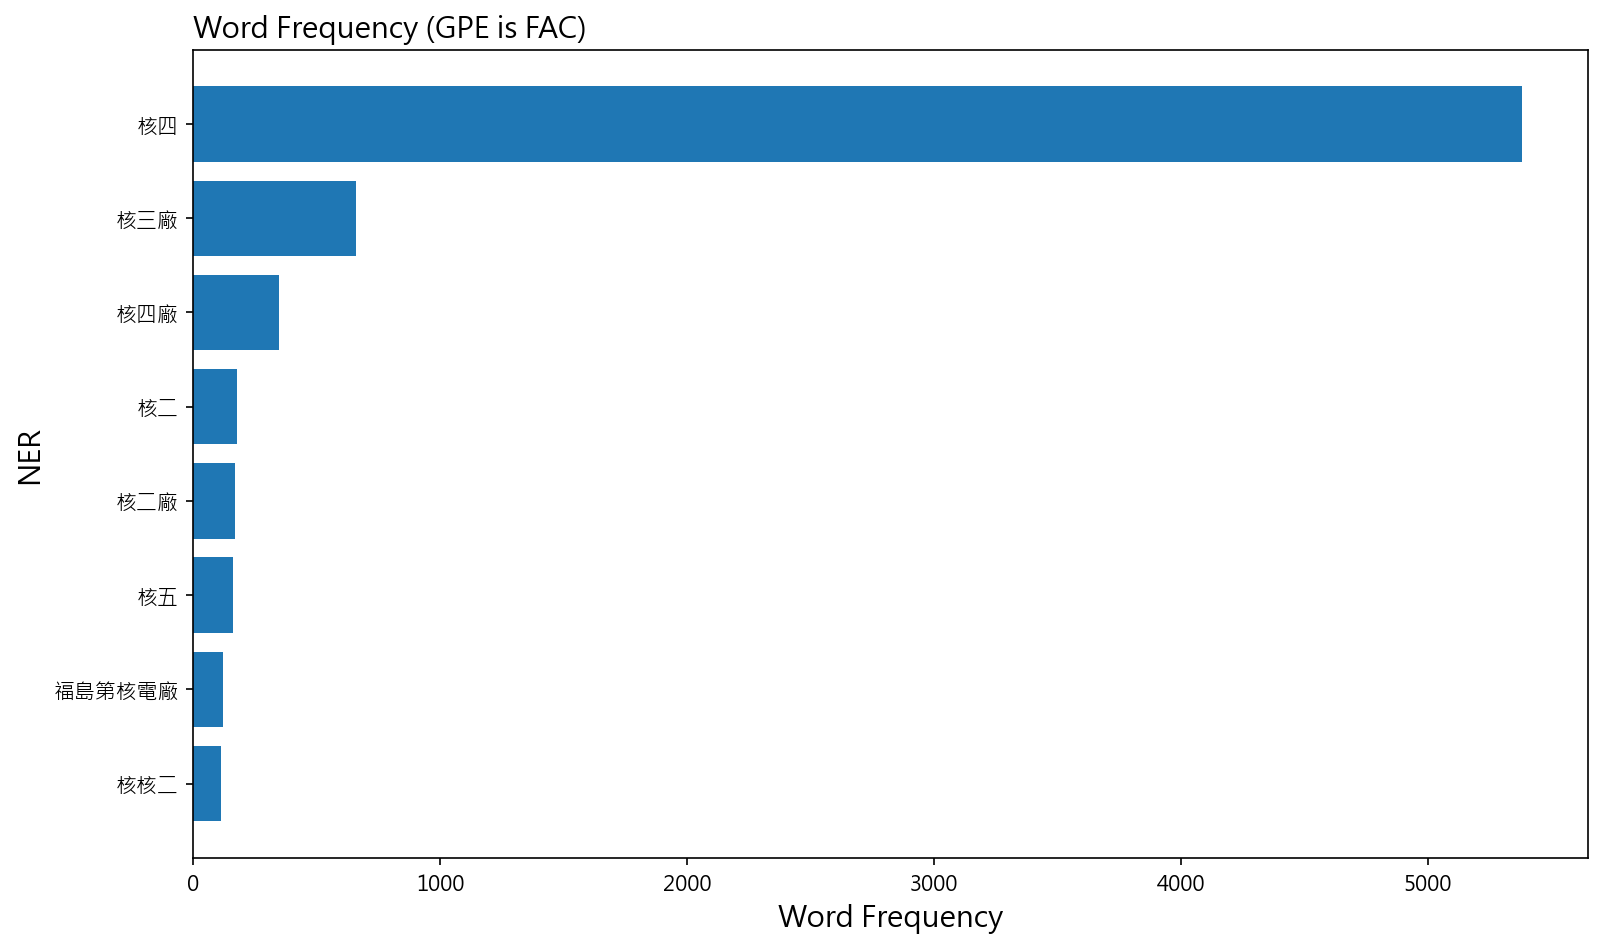

In [416]:
# ÁØ©ÈÅ∏nerÁÇ∫FACÁöÑË≥áÊñô
l_noun = ["FAC"]
FAC = entity_table[entity_table.ner.isin(l_noun)]

# Ë®àÁÆóÊØèÂÄãÂêçË©ûÊèêÂà∞ÁöÑÊ¨°Êï∏ÔºåÈÅ∏Âá∫Ââç8ÂÄã
ner_count = FAC.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(8).reset_index()

# Ë®≠ÂÆö‰∏≠ÊñáÂ≠óÂΩ¢
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (GPE is FAC)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
# fig.show()

‰∏ãÈù¢ÊâæÂá∫„ÄåÊ†∏Âõõ„Äç„ÄÅ„ÄåÊ†∏Âõõ+Ë≥¥Ê∏ÖÂæ∑„ÄçÁõ∏ÈóúÊñáÁ´†ÔºåËàáÂæåÁ∫åÊÉÖÁ∑íÂàÜÊûê‰∏ÄËµ∑ÂÅöÊé¢Á¥¢‰∏¶Â∞çÊØî

In [420]:
keyword_list = ['Ê†∏Âõõ']
N4_selected = df[df['artContent'].fillna('').str.contains('|'.join(keyword_list), regex=True)]
print(f"{' '.join(keyword_list)}Ôºö{N4_selected.shape[0]}ÁØáÁõ∏ÈóúË≤ºÊñá")
N4_selected.head(3)

Ê†∏ÂõõÔºö2456ÁØáÁõ∏ÈóúË≤ºÊñá


system_id                                             artUrl  \
4           5  https://www.ptt.cc/bbs/HatePolitics/M.16231218...   
7           8  https://www.ptt.cc/bbs/HatePolitics/M.16234727...   
11         12  https://www.ptt.cc/bbs/HatePolitics/M.16236568...   

                       artTitle     artDate    artPoster   artCatagory  \
4   Re:[Êñ∞ËÅû]5ÊúàÂ∫ïË´ãËæ≠Èô≥ÂüπÂì≤:ÊúÄÂ§ßÂõ∞Èõ£Â∞±ÊòØ‰æÜËá™Ëî°Ëã±Êñá  2021-06-08       areses  HatePolitics   
7        [Ë®éË´ñ]È¶¨Ëã±‰πùË∂ÖÁ¥öÊ≤íÊúâÊìîÁï∂ÔºåÈÄÄ‰ºëÈÇÑ‰∏çÊîæÈÅéÂè∞ÁÅ£  2021-06-12       oftisa  HatePolitics   
11      [Êñ∞ËÅû]CNNÁàÜÂè∞Â±±Ê†∏ÈõªÂª†ÁñëÊ¥©ÊîæÂ∞ÑÁâ©Ë≥™‰∏≠Êñπ‰∏çÊñ∑  2021-06-14  meredith001  HatePolitics   

                                           artContent  \
4   ÈõñÁÑ∂ÊàëÂÄë‰∏ÄÁõ¥Ë™™ÊîøÊ≤ª‰∏çËÉΩÂáåÈßïÊñºÁßëÂ≠∏Ôºå‰ΩÜÈÇ£ÊòØÊ≠£Â∏∏ÊÉÖÊ≥Å‰∏ãÔºåÊîøÊ≤ªÊú¨‰æÜÂ∞±ÊòØ‰∏ÄÂàáÁ§æÊúÉÈóú‰øÇÁöÑÁ∏Ω\nÂíåÔºå‰πüÊòØ...   
7   ÁæéË±¨ÁæéÁâõÂïèÈ°åÊó•Êú¨„ÄÅÈüìÂúã‰πüÊúâÊäóË≠∞\nÈüìÂúãÁöÑÊäóË≠∞ÈùûÂ∏∏ÁåõÁàÜÔºåÊó•Êú¨Âè™ÊúâÈªëÈÅìË¨ùÁΩ™ÊàñÊòØÈÄÄÂπ´ÊâçË¶ÅÂàáÊâãÊåá\n...   
11  1.Êñ∞ËÅûÁ∂≤ÂùÄÔ∏∞\nhttps://hk.appledaily.com/internation...   

                                           artComment             e_ip  \
4   [{"cmtStatus": "Âôì", "cmtPoster": "JamesSoong",...   223.104.20.205   
7   [{"cmtStatus": "‚Üí", "cmtPoster": "goetze", "cm...   111.185.129.19   
11  [{"cmtStatus": "Êé®", "cmtPoster": "a0986188522"...  122.116.197.102   

           insertedDate dataSource  
4   2021-06-09 01:53:43        ptt  
7   2021-06-13 02:05:13        ptt  
11  2021-06-15 01:38:19        ptt

In [422]:
keyword_list1 = ['Ê†∏Âõõ', 'Ë≥¥Ê∏ÖÂæ∑']
mask = df['artContent'].fillna('').apply(lambda x: all(kw in x for kw in keyword_list1))
N4Lai_selected = df[mask]
print(f"{' '.join(keyword_list1)}Ôºö{N4Lai_selected.shape[0]}ÁØáÁõ∏ÈóúË≤ºÊñá")
N4Lai_selected.head(3)

Ê†∏Âõõ Ë≥¥Ê∏ÖÂæ∑Ôºö215ÁØáÁõ∏ÈóúË≤ºÊñá


system_id                                             artUrl  \
22          23  https://www.ptt.cc/bbs/HatePolitics/M.16238316...   
154        155  https://www.ptt.cc/bbs/HatePolitics/M.16356072...   
162        163  https://www.ptt.cc/bbs/HatePolitics/M.16357386...   

                      artTitle     artDate  artPoster   artCatagory  \
22   Re:[Ë®éË´ñ]ÊüØÊñáÂì≤ÈÇÑÊúâËá™‰ø°Ë™™Êàë‰æÜÊåáÊèÆ‰∏çÊúÉÂ§™Â∑ÆÂóéÔºü  2021-06-16   Sosonian  HatePolitics   
154     [Êñ∞ËÅû]ÂπïÂæå„ÄãÂÖ¨ÊäïË™™ÊòéÊúÉÊ°ÉÂúíÈ¶ñÁôºÂÅöÁêÉÈÑ≠ÊñáÁá¶Ôºü  2021-10-30       zkow  HatePolitics   
162     [Êñ∞ËÅû]Ë≥¥Ê∏ÖÂæ∑ÔºöÂÖ¨ÊäïÊ°àÁâΩÊ∂âÂè∞ÁÅ£Âç±Ê©üËã•ÈÅéÈóúÂ∞áÈù¢  2021-11-01  nightwing  HatePolitics   

                                            artContent  \
22   ÈÄôÁ®ÆÂª¢ÊñáÔºåÈö®‰æøÊãøÂì™ÂÄãÊîøÊ≤ª‰∫∫Áâ©‰æÜÂ•óÈÉΩÂèØ‰ª•\n\nÂÅáË®≠ÁèæÂú®ÊòØÈ¶¨Ëã±‰πùÈÇÑÂú®Áï∂Á∏ΩÁµ±ÔºåËî°Ëã±ÊñáÊâπÊ†∏ÂõõÊîøÁ≠ñÔºå...   
154  ÂπïÂæå„ÄãÂÖ¨ÊäïË™™ÊòéÊúÉÊ°ÉÂúíÈ¶ñÁôºÂÅöÁêÉÈÑ≠ÊñáÁá¶ÔºüÊ∞ëÈÄ≤Èª®È†ÜÂ∫èÂÆâÊéíÂóÖÂá∫2024Á´ØÂÄ™\n\nÈ¢®ÂÇ≥Â™í„ÄÄÈ°èÊåØÂá±\n...   
162  1.Êñ∞ËÅûÁ∂≤ÂùÄÔ∏∞\nhttps://newtalk.tw/news/view/2021-11-...   

                                            artComment             e_ip  \
22   [{"cmtStatus": "Âôì", "cmtPoster": "nepenthes7",...    114.198.166.7   
154  [{"cmtStatus": "Êé®", "cmtPoster": "albert1229",...  123.192.113.200   
162  [{"cmtStatus": "Êé®", "cmtPoster": "a0986188522"...     106.1.248.69   

            insertedDate dataSource  
22   2021-06-17 01:26:40        ptt  
154  2021-10-31 00:44:12        ptt  
162  2021-11-02 00:39:56        ptt

## Âà©Áî®SnowNLPÈÄ≤Ë°åÊÉÖÁ∑íÂàÜÊûê

In [432]:
from snownlp import SnowNLP

sentence_table = pd.read_csv("sentence_table_Nu.csv") #ÂåØË≥áÊñô
sentence_table1 = pd.read_csv("sentence_table_Nu.csv") 

sentiment_date = pd.merge(sentence_table,N4_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()
sentiment_date1 = pd.merge(sentence_table,N4Lai_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()


def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# Âπ´ÊØèÂè•Ë©±Âä†‰∏äÊÉÖÁ∑íÂàÜÊï∏
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date1['sentimentValue'] = sentiment_date1.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)

sentiment_date['sentimentValue'].describe()
sentiment_date1['sentimentValue'].describe()


count    2.373400e+04
mean     3.967722e-01
std      3.150285e-01
min      3.328879e-10
25%      1.186589e-01
50%      2.935473e-01
75%      6.417925e-01
max      9.999977e-01
Name: sentimentValue, dtype: float64

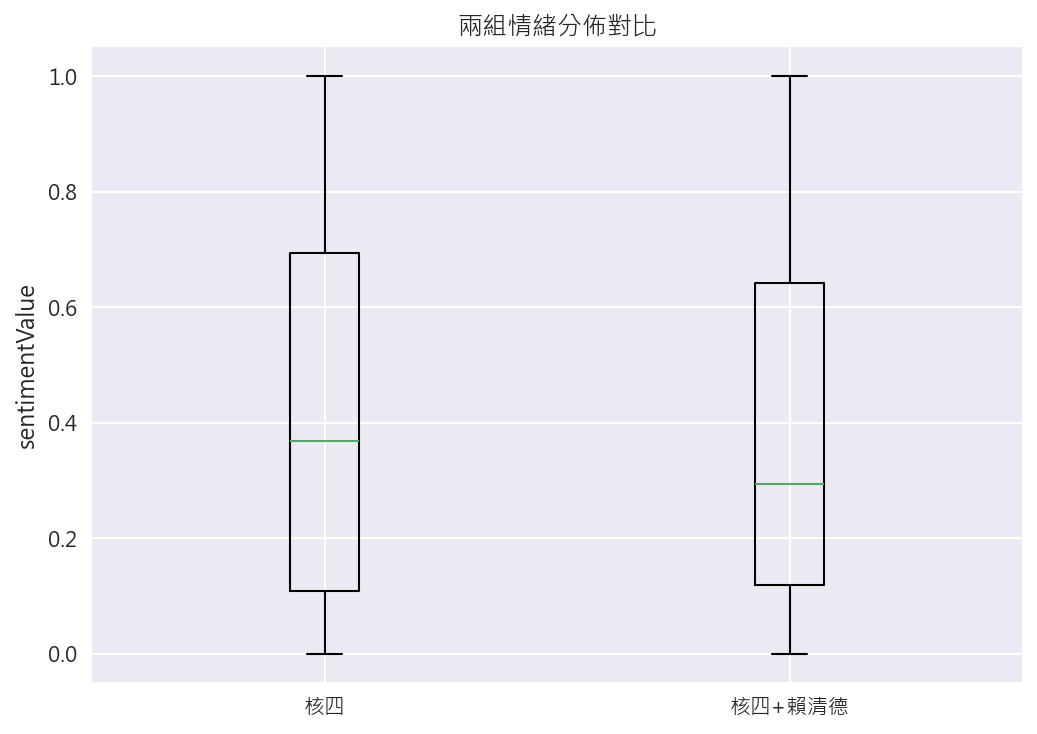

In [435]:
# ÊÉÖÁ∑íÂàÜÂ∏ÉÁöÑÁõíÁãÄÂúñ
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # ‰ΩøÁî®ÂæÆËªüÊ≠£ÈªëÈ´îÈ°ØÁ§∫‰∏≠Êñá
plt.rcParams['axes.unicode_minus'] = False

data_to_plot = [
    sentiment_date['sentimentValue'].dropna(),
    sentiment_date1['sentimentValue'].dropna()
]

plt.boxplot(data_to_plot, labels=['Ê†∏Âõõ', 'Ê†∏Âõõ+Ë≥¥Ê∏ÖÂæ∑'], showfliers=False)
plt.title('ÂÖ©ÁµÑÊÉÖÁ∑íÂàÜ‰ΩàÂ∞çÊØî')
plt.ylabel('sentimentValue')
plt.grid(True)
plt.show()

‰∏≠‰ΩçÊï∏Â∑ÆÁï∞Ôºö<br>
„ÄåÊ†∏Âõõ„ÄçÁöÑÊÉÖÁ∑í‰∏≠‰ΩçÊï∏Áï•È´òÔºàÁ¥Ñ 0.38ÔºâÔºõ<br>
„ÄåÊ†∏Âõõ+Ë≥¥Ê∏ÖÂæ∑„Äç‰∏≠‰ΩçÊï∏Áï•‰ΩéÔºàÁ¥Ñ 0.3 Â∑¶Âè≥Ôºâ„ÄÇ<br>

IQRÔºàÂõõÂàÜ‰ΩçË∑ùÔºâÂ∑Æ‰∏çÂ§öÔºå‰ΩÜ„ÄåÊ†∏Âõõ+Ë≥¥Ê∏ÖÂæ∑„ÄçÊúâÊõ¥Â§ö‰ΩéÊÉÖÁ∑íÂÄºÔºåË°®Á§∫ËàáÊîøÊ≤ª‰∫∫Áâ©ÈÄ£ÁµêÂæåÔºåÊÉÖÁ∑íÊõ¥Ê•µÁ´Ø„ÄÅÊõ¥ÂàÜÂåñ„ÄÇ<br>

Êé®Ë´ñÔºö<br>
Â∞áÊ†∏ÈõªËàáÊîøÊ≤ª‰∫∫Áâ©ÔºàË≥¥Ê∏ÖÂæ∑ÔºâÈÄ£ÁµêÂæåÔºåË®éË´ñÊÉÖÁ∑íÂÅèÂêëÊõ¥Ë≤†Èù¢Ôºå‰ª£Ë°®Ê†∏ÈõªË≠∞È°å‰∏ÄÊó¶ËàáÈÅ∏ËàâÊàñÊîøÈª®ÊéõÈâ§ÔºåÊÉÖÁ∑íÂàÜÊ≠ßÊõ¥ÂäáÁÉà„ÄÇ

In [446]:
sent_date = sentiment_date.copy()
sent_date1 = sentiment_date1.copy()

sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('M')
sent_date1['artDate'] =  pd.to_datetime(sentiment_date1['artDate']).dt.to_period('M')

sentiment_count  = (sent_date.groupby('artDate')['sentimentValue'].mean().reset_index().rename(columns={'sentimentValue':'sent_mean_A'}))
sentiment_count1 = (sent_date1.groupby('artDate')['sentimentValue'].mean().reset_index().rename(columns={'sentimentValue':'sent_mean_B'}))

sentiment_count['artDate_dt']  = sentiment_count['artDate'].dt.to_timestamp()
sentiment_count1['artDate_dt'] = sentiment_count1['artDate'].dt.to_timestamp()


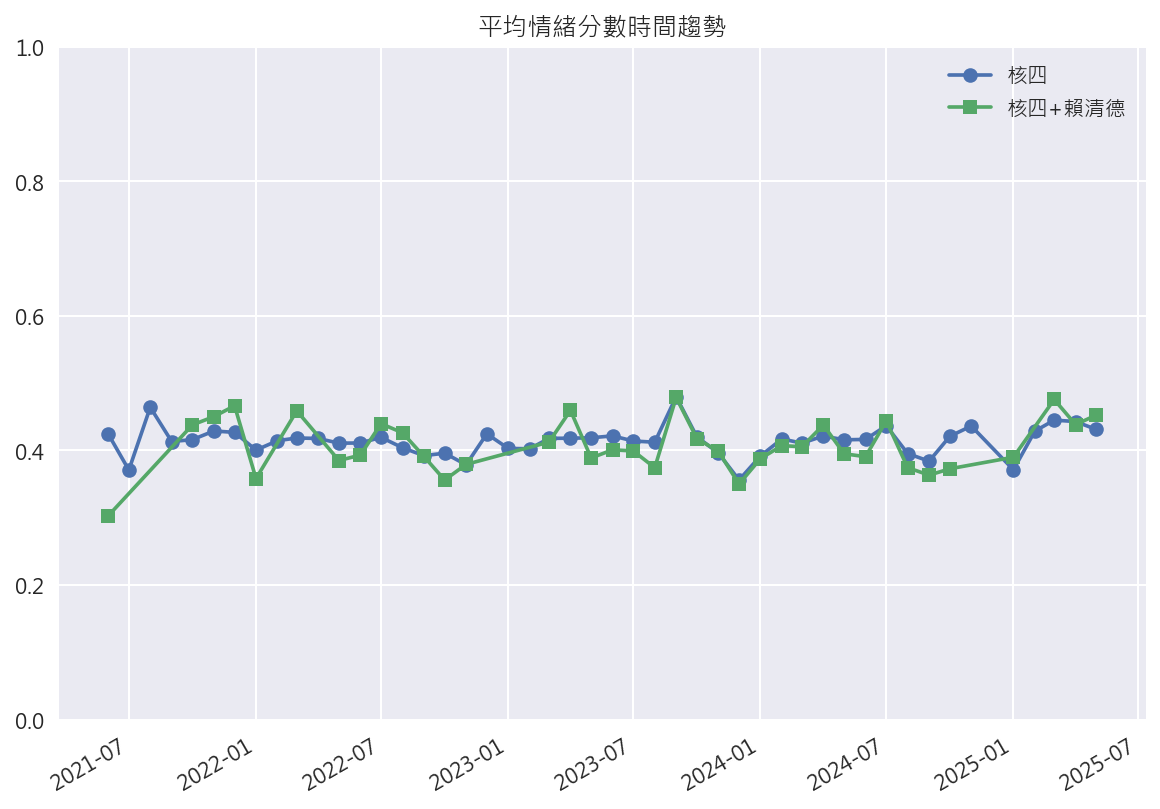

In [448]:
# Âπ≥ÂùáÊÉÖÁ∑íÂàÜÊï∏ÊôÇÈñìË∂®Âã¢
months = [period.to_timestamp() for period in sentiment_count['artDate']]   # Â∞á PeriodIndex ‰∏≠ÁöÑÊØèÂÄã Period Áâ©‰ª∂ËΩâÊèõÁÇ∫Â∞çÊáâÁöÑ datetime Áâ©‰ª∂
y = sentiment_count['sent_mean_A']
months1 = [period.to_timestamp() for period in sentiment_count1['artDate']]   # Â∞á PeriodIndex ‰∏≠ÁöÑÊØèÂÄã Period Áâ©‰ª∂ËΩâÊèõÁÇ∫Â∞çÊáâÁöÑ datetime Áâ©‰ª∂
y1 = sentiment_count1['sent_mean_B']


plt.plot_date(months,  y,  fmt='-o', label='Ê†∏Âõõ')
plt.plot_date(months1, y1, fmt='-s', label='Ê†∏Âõõ+Ë≥¥Ê∏ÖÂæ∑')

plt.title('Âπ≥ÂùáÊÉÖÁ∑íÂàÜÊï∏ÊôÇÈñìË∂®Âã¢')
plt.legend()

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.ylim(0, 1)
plt.show()




ÂèØ‰ª•ÁôºÁèæÔºö<br>
Âú®Â§öÊï∏ÊôÇÊúüÔºå„ÄåÊ†∏Âõõ+Ë≥¥Ê∏ÖÂæ∑„ÄçÁöÑÂπ≥ÂùáÊÉÖÁ∑íÁï•‰ΩéÔºåÁâπÂà•Âú® 2022 Âàù„ÄÅ2023 ÂàùËàá 2025 Âàù ÁöÑÂπæÂÄãÈªûÂá∫ÁèæËºÉÊòéÈ°ØËêΩÂ∑ÆÔºõ<br>
2025 Âπ¥‰∏≠ÈñãÂßãË∂®Êñº‰∏ÄËá¥‰∏îÁï•ÁÇ∫‰∏äÂçáÔºåÂèØËÉΩËàáÈÅ∏ÂæåÊ∞õÂúç„ÄÅÊîøÁ≠ñÂÆöÊ°àÁ≠âÁõ∏Èóú„ÄÇ<br>

Ë£úÂÖÖÊé®Ë´ñÔºö<br>
È´òÂ≥∞ÊôÇÈñì‰∏ÄËá¥‰ΩÜÊÉÖÁ∑íÈ´ò‰ΩéÊúâÂ∑ÆÔºöË™™Êòé‰∫ã‰ª∂Êú¨Ë∫´È©ÖÂãïË®éË´ñÔºå‰ΩÜ‰∫∫Áâ©ÈÄ£ÁµêÊîæÂ§ß‰∫ÜÂ∞çÁ´ãÊàñÂÅèË¶ã„ÄÇ

## Ë©ûÂΩôÊé¢Á¥¢

In [449]:
filter_sentiment = sent_date[sent_date['artDate']=='2024-11']
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] < 0.35]

filter_sentiment.head()

system_id      sentence  artDate dataSource  sentimentValue
104859       3600   ÊñπÂúìÂçÅÂÖ¨ÈáåÂúüÂú∞ÂÖ®ÈÉ®ÂæµÊî∂  2024-11        ptt        0.289525
104862       3600        Ê†∏Âª¢ÊñôÁöÑÂïèÈ°å  2024-11        ptt        0.209684
104863       3600  Âè∞ÁÅ£ÂæàÂ§öÁÑ°‰∫∫Â≥∂ÂèØ‰ª•ËôïÁêÜÈòø  2024-11        ptt        0.110700
104864       3600           Âü∫ÈöÜÂ∂º  2024-11        ptt        0.104252
104866       3600           Ê£âËä±Â∂º  2024-11        ptt        0.331020

In [450]:
pos_words = pd.merge(filter_sentiment,pos_table,on='system_id',how='left')
pos_words = pos_words[['system_id','sentimentValue','word']]
pos_words.head()

system_id  sentimentValue word
0       3600        0.289525   Ê†∏Âõõ
1       3600        0.289525    Ëìã
2       3600        0.289525    Âú®
3       3600        0.289525   Ë≤¢ÂØÆ
4       3600        0.289525   ÈÇ£ÈÇä

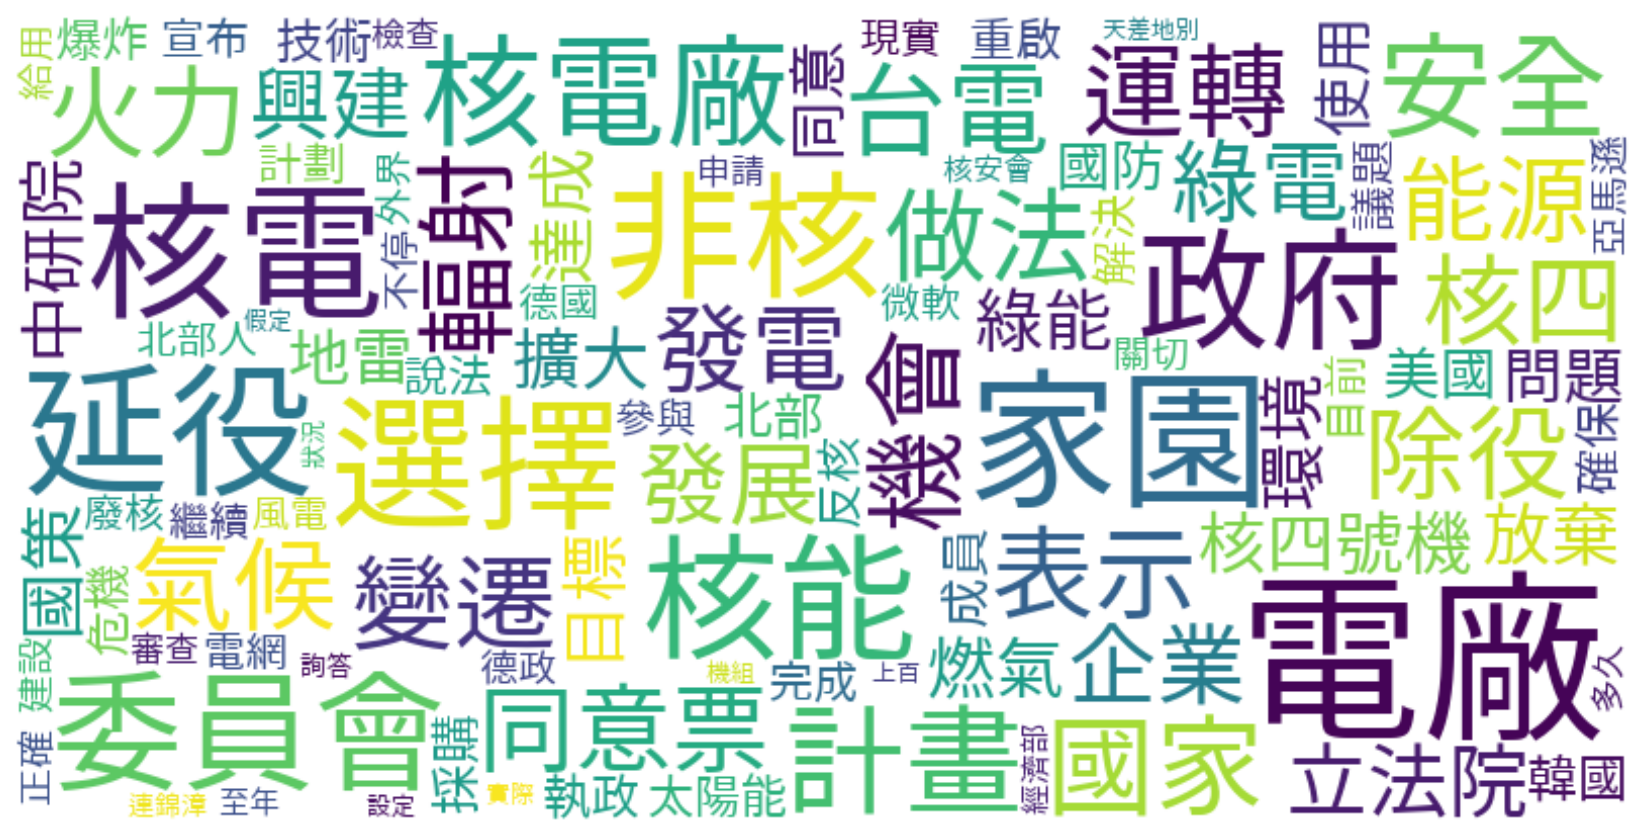

In [456]:
pos_words = pos_words[pos_words.apply(lambda x: len(x['word'])>1, axis=1)]
# Ëá™ÂÆöÂÅúÁî®Â≠ó
with open('stopwords.txt') as f:
    stop_words = f.read().splitlines()

stop_words_pos = stop_words
stop_words_pos.extend(('ÊàëÂÄë','ÂèØ‰ª•','ÁèæÂú®','ÁÑ∂Âæå','Ë´ãÂïè','Âè∞ÁÅ£','‰∏ñÁïå','‰πãÂæå','ÂèØËÉΩ','ÁîöËá≥','‰ªäÂ§©','ÊÄéÈ∫º','ÈúÄË¶Å','ÊÉ≥Ë¶Å','Èô¢Èï∑','Ëá™Â∑±',
'Â∑≤Á∂ì','‰ªª‰Ωï','ÊôÇÈñì','Áï∂ÁÑ∂','Ë∑≥Âá∫‰æÜ','Êó¢ÁÑ∂','Â¶ÇÊûú','Êú¨‰æÜ','‰∏çÊúÉ','ÈÉ≠Êô∫','Âã¢Âäõ','Â•ΩÂÉè','Âè´ÂÅö','ÁúãÂà∞','Ë®òËÄÖÊúÉ','ÁÆóÂá∫‰æÜ','Ê¨°Èï∑','‰∏ä‰ªª','Á∂ìÊøüÈÉ®Èï∑','ÂÆòÂì°','Â∏∏Âãô',
'Â∑¶Âè≥','ÂèçÊ≠£','Ë∑ëÂéª'))
stop_words_pos = set(stop_words_pos)

# Ë®≠ÂÆö‰∏≠ÊñáÂ≠óÂΩ¢
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# ÂèØ‰ª•Ë®≠ÂÆöÂ≠óÂûãÂ§ßÂ∞èÂíåËÉåÊôØÈ°èËâ≤
wordcloud = WordCloud(
                stopwords=stop_words_pos,
                collocations=False,
                font_path=font_path,
                width=800, 
                height = 400, 
                max_words=100, 
                background_color="white")

wordcloud.generate(' '.join(pos_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

Ëß£ËÆÄÔºö<br>
Ë≠∞È°å‰∏ªËª∏ÂæûÊäÄË°ìËΩâÁÇ∫ÊîøÁ≠ñËàáÊîøÊ≤ª<br>
„ÄåÊ†∏Âõõ+Ë≥¥Ê∏ÖÂæ∑„ÄçÁõ∏ÈóúË®éË´ñ‰∏≠ÔºåÊîøÁ≠ñË™ûË®ÄÂá∫ÁèæÁéá‰∏äÂçáÔºå‰æãÂ¶Ç„ÄåÈô§ÂΩπ„Äç„ÄåÈùûÊ†∏„Äç„ÄåÈÅ∏Êìá„Äç„ÄåÂßîÂì°ÊúÉ„ÄçÔºåÈ°ØÁ§∫ÁÑ¶ÈªûËΩâÂêëÊ±∫Á≠ñÊ≠£Áï∂ÊÄßËàáÊîøÊ≤ªÁ´ãÂ†¥„ÄÇ<br>

Âá∫ÁèæÊîøÈª®Ë™ûÊÑèËàáÊîøÁ∏æË©ûÂΩô<br>
Â¶Ç„ÄåÂæ∑Êîø„Äç„ÄåËààÂª∫„Äç„ÄåÊ≠£Á¢∫„Äç„ÄåÈô§ÂΩπ„Äç„ÄåÁ∫åÂª∫„ÄçÁ≠âÔºåÂèØËÉΩÂ∏∂ÊúâÊòéÈ°ØÁöÑÊîøÊ≤ªÊÉÖÁ∑íÂÇæÂêëÊàñËÇØÂÆö/Âê¶ÂÆöÁ´ãÂ†¥„ÄÇ<br>

Â§öÈáçËÉΩÊ∫êÂ∞çÊØîË™ûÂ¢ÉÂº∑ÁÉà<br>
„ÄåÊ†∏Èõª„ÄçËàá„ÄåÁ∂†Èõª„Äç„ÄåÁÅ´Âäõ„ÄçÂêåÊôÇË¢´Ë®éË´ñÔºåÈ°ØÁ§∫ËºøË´ñ‰∏çÂÉÖËÅöÁÑ¶Âú®Ê†∏ÈõªÊú¨Ë∫´Ôºå‰πüÂú®ÊØîËºÉËÉΩÊ∫êÈÅ∏ÊìáËÉåÂæåÁöÑÂÉπÂÄºËßÄËàáÊîøÁ≠ñË∑ØÁ∑ö„ÄÇ

# ‰∏ªÈ°åÊ®°Âûã

ËºâÂÖ•Ë≥áÊñô

In [ ]:
df = pd.read_csv("PTT_Nuclear.csv")
print(df.shape, df.columns)


(13622, 11) Index(['system_id', 'artUrl', 'artTitle', 'artDate', 'artPoster',
       'artCatagory', 'artContent', 'artComment', 'e_ip', 'insertedDate',
       'dataSource'],
      dtype='object')


‰æù„ÄåÊèêÂà∞Ê¨°Êï∏„ÄçËá™ÂãïÊ®ôË®ªÊîøÈª®

In [482]:
party_kw = {
    "ÂúãÊ∞ëÈª®":  r"ÂúãÊ∞ëÈª®|KMT|ËóçÁáü|Êú±Á´ãÂÄ´|È¶¨Ëã±‰πù|‰æØÂèãÂÆú",
    "Ê∞ëÈÄ≤Èª®":  r"Ê∞ëÈÄ≤Èª®|DPP|Á∂†Ááü|Ëî°Ëã±Êñá|Ë≥¥Ê∏ÖÂæ∑|ËòáË≤ûÊòå",
    "Ê∞ëÁúæÈª®":  r"Ê∞ëÁúæÈª®|TPP|ÁôΩÁáü|ÊüØÊñáÂì≤|ÊüØ‰∏ªÂ∏≠|ÈªÉÂúãÊòå",
}
def tag_party_by_count(row):
    text = f"{row.artTitle} {row.artContent}"
    counts = {p: len(re.findall(pattern, text, flags=re.I))
              for p, pattern in party_kw.items()}
    # ÂèñÊúÄÈ´òÂÄº
    best_party, best_cnt = max(counts.items(), key=lambda x: x[1])
    # Ëã•ÂÆåÂÖ®Ê≤íÂá∫Áèæ ‚Üí ÂÖ∂‰ªñ
    return best_party if best_cnt > 0 else "ÂÖ∂‰ªñ"

df_nuke["party"] = df_nuke.apply(tag_party_by_count, axis=1)
print(df_nuke["party"].value_counts())

party
Ê∞ëÈÄ≤Èª®    2492
ÂúãÊ∞ëÈª®    1653
Ê∞ëÁúæÈª®     586
Name: count, dtype: int64


ËºâÂÖ•ÂÅúÁî®Ë©û & Êñ∑Ë©û

In [500]:
import re, jieba, string

with open("stopwords.txt", encoding="utf-8") as f:
    STOPWORDS = {w.strip() for w in f if w.strip()}

extra_stop = """
ÂúãÊ∞ëÈª® Ê∞ëÈÄ≤Èª® Ê∞ëÁúæÈª® ËóçÁ∂† ËóçÁôΩ
ÊüØÊñáÂì≤ Ë≥¥Ê∏ÖÂæ∑ ‰æØÂèãÂÆú Êú±Á´ãÂÄ´ Ëî°Ëã±Êñá ÈªÉÂúãÊòå ËòáË≤ûÊòå ÈÉ≠Âè∞Èäò Âê≥Ê¨£Áõà Ë≥¥ÂìÅÂ¶§
Âè∞ÁÅ£ ‰∏≠Âúã ÁæéÂúã Â§ßÈô∏ ‰øÑÁæÖÊñØ ÁÉèÂÖãËò≠ ÂÖ©Â≤∏ Êó•Êú¨
ÂúãÂÆ∂ Êñ∞ËÅû Â™íÈ´î Ë®òËÄÖ ÂÖ¨Âè∏ 
Áõ¥Êé• Ê†πÊú¨ ÈÄôÁ®Æ Áü•ÈÅì Ë≥¥ÁöÆ ÈòøÂåó 
""".split()
STOPWORDS.update(extra_stop)

#Êñ∑Ë©ûÂáΩÂºè
def clean_cut(text: str):
    text = re.sub(r"http\S+|www\S+", "", text)      # ÂéªÁ∂≤ÂùÄ
    text = re.sub(r"[0-9A-Za-z]+", "", text)        # ÂéªËã±Êï∏
    tokens = [
        t for t in jieba.lcut(text)
        if (
            t.strip()                          # ÂéªÁ©∫Â≠ó‰∏≤
            and len(t) > 1                     # Âè™ÁïôÂÖ©Â≠ó‰ª•‰∏ä
            and t not in STOPWORDS
            and t not in string.punctuation
        )
    ]
    return tokens
    
df_nuke["artContent"] = df_nuke["artContent"].fillna("")

#Êñ∞Â¢û tokens Ê¨Ñ
df_nuke["tokens"] = df_nuke["artContent"].apply(clean_cut)

‰ª•‰∏âÂÄãÊîøÈª®‰æÜË®ìÁ∑¥ LDA

In [501]:
NUM_TOPICS   = 4     # 3,5,7
RANDOM_STATE = 2025

lda_dict, lda_corpus, lda_model = {}, {}, {}

for p, sub in df_nuke.groupby("party"):
    tokenized = sub["tokens"].tolist()
    dictionary = Dictionary(tokenized)
    corpus     = [dictionary.doc2bow(t) for t in tokenized]
    lda        = LdaModel(
        corpus=corpus, id2word=dictionary,
        num_topics=NUM_TOPICS, random_state=RANDOM_STATE,
        chunksize=200, passes=10
    )
    lda_dict[p], lda_corpus[p], lda_model[p] = dictionary, corpus, lda
    
    print(f"\n=== {p} ===")
    for i, topic in lda.show_topics(num_words=10, formatted=False):
        words = " ".join(w for w, _ in topic)
        print(f"Topic {i}: {words}")



=== ÂúãÊ∞ëÈª® ===
Topic 0: ÂÆâÂÖ® ÂúãÈò≤ ÂúãÂÆâ Á∂ìÊøü ÈáçË¶Å Èóú‰øÇ ‰∏≠ÂÖ± È†êÁÆó ‰∏≠ËèØÊ∞ëÂúã ÈúÄË¶Å
Topic 1: Ê†∏Âõõ Âª¢Êñô Ê†∏Èõª Ê†∏ÈõªÂª† ÈáçÂïü ÂÖ¨Êäï Êñ∞Âåó ËôïÁêÜ Ê†∏ËÉΩ ÂèçÂ∞ç
Topic 2: Âè∞Èõª ËÉΩÊ∫ê Ê†∏Èõª ÈõªÂÉπ Âª∂ÂΩπ Ê†∏ËÉΩ ÊîøÁ≠ñ ÁôºÈõª ÊàêÊú¨ ÂÆâÂÖ®
Topic 3: ÂÖ¨Êäï Á´ãÂßî ÁΩ∑ÂÖç Ê∞ë‰∏ª ÂÆåÊï¥ Ê∞ëÁúæ Âì°Â∑• ‰ªäÂ§© Ê≥ïÊ°à Âª¢Ê≠ª

=== Ê∞ëÁúæÈª® ===
Topic 0: Á´ãÂßî Ê†∏Èõª ÂÖ¨Êäï Ê∞ëÁúæ ÂÆåÊï¥ Áº∫Èõª ÈáçÂïü ÂÅúÈõª Âª¢Êñô Ê†∏ÈõªÂª†
Topic 1: Ê†∏Èõª Ê†∏Âõõ ÂÖ¨Êäï ÂèçÊ†∏ Âè∞Èõª Âª∂ÂΩπ ÊîØÊåÅ Ê†∏‰∏â ËÉΩÊ∫ê Á∂†Èõª
Topic 2: ËÉΩÊ∫ê Ê†∏Èõª Ê†∏ËÉΩ ÂÜçÁîü ÁôºÂ±ï ÂÆåÊï¥ ÊîøÁ≠ñ Âè∞Èõª Á∂†Èõª Ê∞ëÁúæ
Topic 3: ËªçÈöä È£õÂΩà ‰øÑËªç Âú∞ÂçÄ ÊîªÊìä ÈÄ≤Ë°å Ëªç‰∫ã ÁπºÁ∫å ÁÑ°‰∫∫Ê©ü Ê∂àÊÅØ

=== Ê∞ëÈÄ≤Èª® ===
Topic 0: ÂÖ¨Êäï ÊîØÊåÅ Ê†∏Èõª Ê∞ë‰∏ª Ê†∏Âõõ ÂèçÊ†∏ Âü∑Êîø ÂèçÂ∞ç ÁúãÂà∞ ‰∏≠ÂÖ±
Topic 1: Âè∞Èõª Ê†∏Èõª Ê†∏ËÉΩ ËÉΩÊ∫ê Á∂†Èõª ÁôºÈõª ÈõªÂÉπ ÈõªÂäõ Ê†∏ÈõªÂª† Á∂†ËÉΩ
Topic 2: ËÉΩÊ∫ê ÂÆåÊï¥ Ê†∏ËÉΩ ÊîøÁ≠ñ ÈùûÊ†∏ Á´ãÂßî Á§æÊúÉ ÂÆ∂Âúí ÁôºÂ±ï Êú™‰æÜ
Topic 3: Âè∞Âçó Èõ≤Ë±π È†êÁÆó Á∂†ËÉΩ Á∂†Èõª Áñ´Ëãó ÂÖâÈõ

üîµ ÂúãÊ∞ëÈª®Ôºö<br>
Topic 0ÔºàÊîøÊ≤ªËàáÊà∞Áï•ÂÆâÂÖ®ÈóúËÅØÔºâ<br>
ÈóúÈçµË©ûÔºöÂÆâÂÖ®„ÄÅÂúãÈò≤„ÄÅÂúãÂÆâ„ÄÅÁ∂ìÊøü„ÄÅÈóú‰øÇ„ÄÅ‰∏≠ÂÖ±„ÄÅÈ†êÁÆó<br>
Ëß£ËÆÄÔºöÂÅèÂêëÊà∞Áï•„ÄÅÂúãÂÆ∂ÂÆâÂÖ®ËàáÁ∂ìÊøüÊîøÁ≠ñË´ñËø∞Ôºå‰∏ªÊâì„ÄåÂ§ßÂ±ÄÁ©©ÂÆö„ÄçËàá„ÄåÂúãÂÆ∂Âà©Áõä„Äç<br>
È¢®Ê†ºÔºöÂº∑Ë™øÂ§ñÈÉ®Â®ÅËÑÖËàáÂÖßÈÉ®Ê≤ªÁêÜÁµêÊßã„ÄÅÈÄ£ÁµêÂÖ©Â≤∏ÔºèÂúãÈò≤ÊÑèË≠òÂΩ¢ÊÖã<br>

Topic 1ÔºàÊ†∏ÈõªÊ≠£Áï∂ÊÄßËàáÊ∞ëÊÑèÂ∞çÊäóÔºâ<br>
ÈóúÈçµË©ûÔºöÊ†∏Âõõ„ÄÅÂª¢Êñô„ÄÅËôïÁêÜ„ÄÅË≤¢Áçª„ÄÅÂÖ¨Êäï„ÄÅÊñ∞Âåó„ÄÅËÉΩÊ∫ê„ÄÅÂèçÂ∞ç<br>
Ëß£ËÆÄÔºöÂëàÁèæÊ†∏ÈõªÁõ∏ÈóúÁà≠Ë≠∞ËàáÂú∞Êñπ vs ‰∏≠Â§Æ„ÄÅÊîØÊåÅ vs ÂèçÂ∞çÁöÑÂàÜÊ≠ßË®éË´ñ<br>
È¢®Ê†ºÔºöÊ†∏ÈõªÊòØ‰∏ªËª∏Ôºå‰º¥Èö®ËôïÁêÜÈõ£È°åËàáÊîøÁ≠ñÊãâÊâØÔºàÁâπÂà•ÊòØÂú∞ÂçÄÊ∞ëÊÑèËàáÊ≥ïË¶èÈù¢Ôºâ<br>

Topic 2ÔºàÊ†∏ËÉΩÁ∂ìÊøüËàáÊîøÁ≠ñÂª∂ÂΩπÔºâ<br>
ÈóúÈçµË©ûÔºöËÉΩÊ∫ê„ÄÅÈõªÂÉπ„ÄÅÂª∂ÂΩπ„ÄÅÊîøÁ≠ñ„ÄÅÊàêÊú¨„ÄÅÂÆâÂÖ®<br>
Ëß£ËÆÄÔºöËÅöÁÑ¶Âú®Ê†∏ËÉΩËàáËÉΩÊ∫êÊîøÁ≠ñÁöÑÊàêÊú¨ÊïàÁõäËàáÂª∂ÂΩπÁÆ°ÁêÜ<br>
È¢®Ê†ºÔºöË®éË´ñÁ∂ìÊøüÂØ¶Ë≥™ËàáËÉΩÊ∫êÈÅ∏ÊìáÔºåÂÅèÊäÄË°ìÊÄßËàáÂØ¶ÂãôÂ∞éÂêë<br>


‚ö™ Ê∞ëÁúæÈª®Ôºö‰∏ªÈ°åÂàÜÊûê<br>
Topic 0ÔºàÂÖ¨ÊäïËàáÊ∞ëÁúæÂü∫Â±§ÂèçÊáâÔºâ<br>
ÈóúÈçµË©ûÔºöÁ´ãÂßî„ÄÅÊ†∏Èõª„ÄÅÂÖ¨Êäï„ÄÅÊ∞ëÁúæ„ÄÅÁº∫Èõª„ÄÅÂÅúÈõª„ÄÅÂª¢Êñô<br>
Ëß£ËÆÄÔºö‰ª•„ÄåÊ∞ëÁúæË¶ñËßí„ÄçÁÇ∫Âá∫ÁôºÈªûÔºåÈóúÊ≥®Âü∫Â±§ËÉΩÊ∫êÂïèÈ°åËàáÂà∂Â∫¶ÈÄèÊòéÊÄß<br>
È¢®Ê†ºÔºöÊ∞ëÊÑèÁÇ∫Â∞éÂêëÔºåÂº∑Ë™øÈõªÂäõÂïèÈ°åËàáÊ∞ëÁîüÂõ∞Â¢ÉÁöÑÂõûÊáâ<br>

Topic 1ÔºàÊîøÁ≠ñË°ùÁ™ÅËàáÊîøÈª®Á´ãÂ†¥‰∫§ÈãíÔºâ<br>
ÈóúÈçµË©ûÔºöÂèçÊ†∏„ÄÅÂª∂ÂΩπ„ÄÅÊîØÊåÅ„ÄÅÁ∂†Èõª„ÄÅÁ∂†Ááü„ÄÅÊ∞ëÁúæ<br>
Ëß£ËÆÄÔºöÊèèÁπ™ÊîøÊ≤ªÁ´ãÂ†¥ÁöÑÁ¢∞ÊíûÔºå‰æãÂ¶ÇÂèçÊ†∏ËàáÊîØÊåÅÊ†∏‰∏¶Â≠òÔºå‰ª•ÂèäÂ∞çÁ∂†ËÉΩÁöÑË≥™Áñë<br>
È¢®Ê†ºÔºöËºÉÂÖ∑Â∞çÊäóÊÄßÔºåÂëàÁèæÂá∫ËÉΩÊ∫êË≠∞È°åË¢´ÊîøÊ≤ªÂåñÁöÑË™ûÂ¢É<br>

Topic 2ÔºàÂú∞Á∑£Ë°ùÁ™ÅËàáËªç‰∫ãÔºâ<br>
ÈóúÈçµË©ûÔºöÈ£õÂΩà„ÄÅ‰øÑËªç„ÄÅÂú∞ÂçÄ„ÄÅÈÄ≤Ë°å„ÄÅÊ©üÂô®„ÄÅÊ∂àÊÅØ<br>
Ëß£ËÆÄÔºöÁ¥çÂÖ•ÂúãÈöõË≠∞È°åÔºàÂ¶ÇÁÉè‰øÑÊà∞Áà≠ÔºâËàáÂúãÈò≤Áõ∏ÈóúË™ûÂΩô<br>
È¢®Ê†ºÔºöËºÉÊÑèÂ§ñÁöÑ‰∏ÄÁæ§ÔºåÁÇ∫ÁâπÂÆöÊôÇÈñìÊÆµÂèóÁÉè‰øÑÊà∞Áà≠ÂΩ±ÈüøÈÄ†ÊàêÁöÑ‰∏ªÈ°åÊºÇÁßª<br>

üü¢ Ê∞ëÈÄ≤Èª®Ôºö‰∏ªÈ°åÂàÜÊûê<br>
Topic 0ÔºàÊîøÁ≠ñË™™ÊòéËàáÊ≤ªÁêÜË´ñËø∞Ôºâ<br>
ÈóúÈçµË©ûÔºöÊîØÊåÅ„ÄÅÊ∞ë‰∏ª„ÄÅÊ†∏Èõª„ÄÅÂèçÊ†∏„ÄÅÂü∑Êîø„ÄÅÈ†êÁÆó„ÄÅ‰∏≠ÂÖ±<br>
Ëß£ËÆÄÔºöÂ∞áÊ†∏ÈõªÁΩÆÊñºÊ∞ë‰∏ª„ÄÅÂü∑ÊîøËàáÂúãÂÆ∂Ê≤ªÁêÜÁöÑËÑàÁµ°‰∏≠<br>
È¢®Ê†ºÔºöÁêÜÊÄßË´ñËø∞È¢®Ê†ºÔºåÂ∏∏Ë¶ãÊñºÊîøÂ∫úÊàñÂü∑ÊîøÂúòÈöäÁöÑÊîøÁ≠ñË°®Ëø∞Ë™ûÊñô<br>

Topic 1ÔºàËÉΩÊ∫êÁµêÊßãËàáÁ§æÊúÉË≠∞È°åÔºâ<br>
ÈóúÈçµË©ûÔºöËÉΩÊ∫ê„ÄÅÊ†∏ËÉΩ„ÄÅÊîøÁ≠ñ„ÄÅÁ§æÊúÉ„ÄÅÊ∞£ÂÄô„ÄÅÊú™‰æÜ<br>
Ëß£ËÆÄÔºöË´áË´ñÊ†∏ËÉΩÂú®Êï¥È´îËÉΩÊ∫êÂ∏ÉÂ±Ä‰∏≠ÁöÑËßíËâ≤ËàáËàáÁ§æÊúÉÊ≠£Áæ©„ÄÅÁí∞Â¢ÉË≠∞È°å‰∫§Áπî<br>
È¢®Ê†ºÔºöÂº∑Ë™øÈ°òÊôØÂ∞éÂêëËàáÊ∞£ÂÄôË≤¨‰ªªÔºàÂ¶ÇËÉΩÊ∫êËΩâÂûãÔºâ<br>

Topic 2ÔºàÁ∂†ËÉΩËàáÂçÄÂüüÊ≤ªÁêÜÔºâ<br>
ÈóúÈçµË©ûÔºöÈ†êÁÆó„ÄÅÁ∂†ËÉΩ„ÄÅÁñ´Ëãó„ÄÅÂÖâÈõª„ÄÅÁ∂†ËÉΩ„ÄÅÂè∞Âçó<br>
Ëß£ËÆÄÔºöÂá∫ÁèæËàáÂú∞ÊñπÊ≤ªÁêÜÔºàÂ¶ÇÈ†êÁÆó„ÄÅÁñ´ËãóÊñΩÊâìÔºâÂíåÁ∂†ËÉΩÈÉ®ÁΩ≤ÁµêÂêàÁöÑÊÉÖÊ≥Å<br>
È¢®Ê†ºÔºöÊîøÁ≠ñÂü∑Ë°åÂ±§Èù¢ÁöÑÁî®Ë™ûÔºåÂÅèË°åÊîøÈù¢ËÄåÈùûË´ñÊà∞<br>

In [504]:
pyLDAvis.enable_notebook() 

for p in lda_model:
    vis = pyLDAvis.gensim_models.prepare(
        lda_model[p], lda_corpus[p], lda_dict[p], sort_topics=False
    )

    print(f"{p} ‰∏ªÈ°å‰∫íÂãïÂúñ")  
    display(vis)   
    pyLDAvis.save_html(vis, f"lda_vis_{p}.html")   


ÂúãÊ∞ëÈª® ‰∏ªÈ°å‰∫íÂãïÂúñ


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.234904 -0.065966       1        1  14.213506
1      0.050705 -0.056053       2        1  29.818374
2      0.168290 -0.095779       3        1  39.902690
3      0.015909  0.217799       4        1  16.065429, topic_info=     Term         Freq        Total Category  logprob  loglift
38     Ê†∏Âõõ  1453.000000  1453.000000  Default  30.0000  30.0000
800    Âè∞Èõª  2516.000000  2516.000000  Default  29.0000  29.0000
437    Âª¢Êñô  1357.000000  1357.000000  Default  28.0000  28.0000
691    ËÉΩÊ∫ê  2241.000000  2241.000000  Default  27.0000  27.0000
1307   ÈõªÂÉπ  1160.000000  1160.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
920    Â∏ÇÈï∑   129.642608   527.256969   Topic4  -5.8788   0.4256
338    Ë≠∞È°å   129.793585   602.163249   Topic4  -5.8777   0.2939
249    Â†±Â∞é   121.318102   438.150003   Topic4  -5.9452   0.5444
40     Ê†∏Èõª   145.051714  2538.528198   Topic4  -5.7665  -1.0337
143    ÊîøÁ≠ñ   126.660284  1308.767371   Topic4  -5.9021  -0.5068

[298 rows x 6 columns], token_table=      Topic      Freq Term
term                      
2218      3  0.998208   .%
0         1  0.126620   ‰∏ÄÁõ¥
0         2  0.663089   ‰∏ÄÁõ¥
0         3  0.169937   ‰∏ÄÁõ¥
0         4  0.039985   ‰∏ÄÁõ¥
...     ...       ...  ...
1514      3  0.440664   Èª®Âúò
1514      4  0.559052   Èª®Âúò
3558      2  0.055053   Èª®ÈÉ®
3558      3  0.018351   Èª®ÈÉ®
3558      4  0.917551   Èª®ÈÉ®

[489 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

Ê∞ëÁúæÈª® ‰∏ªÈ°å‰∫íÂãïÂúñ


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.054834  0.141502       1        1  15.971592
1      0.095650 -0.017905       2        1  28.859518
2      0.066672 -0.115868       3        1  34.778769
3     -0.217156 -0.007730       4        1  20.390121, topic_info=     Term        Freq       Total Category  logprob  loglift
84     ËÉΩÊ∫ê  851.000000  851.000000  Default  30.0000  30.0000
484    Ê†∏Âõõ  378.000000  378.000000  Default  29.0000  29.0000
4200   ËªçÈöä  160.000000  160.000000  Default  28.0000  28.0000
371    ÂÖ¨Êäï  422.000000  422.000000  Default  27.0000  27.0000
302    Á´ãÂßî  265.000000  265.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
28     Â†±Âëä   40.319333   87.697174   Topic4  -6.2465   0.8131
4823   Êà∞Áà≠   39.563163   85.477202   Topic4  -6.2655   0.8198
711    ‰ΩøÁî®   42.184867  155.963970   Topic4  -6.2013   0.2826
35     ÂÆâÂÖ®   42.991112  250.388790   Topic4  -6.1824  -0.1719
471    ÊîØÊåÅ   42.946640  280.195384   Topic4  -6.1834  -0.2854

[311 rows x 6 columns], token_table=      Topic      Freq Term
term                      
330       1  0.015012   .%
330       2  0.120100   .%
330       3  0.855710   .%
0         1  0.077972   ‰∏Ä‰∏ã
0         2  0.888877   ‰∏Ä‰∏ã
...     ...       ...  ...
9261      4  0.959360   Èª®Âúã
603       1  0.140970   Èª®Âúò
603       2  0.135096   Èª®Âúò
603       3  0.634365   Èª®Âúò
603       4  0.093980   Èª®Âúò

[547 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

Ê∞ëÈÄ≤Èª® ‰∏ªÈ°å‰∫íÂãïÂúñ


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.041239 -0.228919       1        1  21.042830
1      0.120152  0.021191       2        1  40.770858
2      0.157058  0.094221       3        1  27.481326
3     -0.235972  0.113508       4        1  10.704986, topic_info=     Term         Freq        Total Category  logprob  loglift
496    Âè∞Èõª  3316.000000  3316.000000  Default  30.0000  30.0000
1540   ÂÆåÊï¥  1056.000000  1056.000000  Default  29.0000  29.0000
1502   Ê†∏ËÉΩ  3264.000000  3264.000000  Default  28.0000  28.0000
1421   Á∂†Èõª  2109.000000  2109.000000  Default  27.0000  27.0000
373    ËÉΩÊ∫ê  4188.000000  4188.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
373    ËÉΩÊ∫ê   113.780254  4188.744894   Topic4  -5.9992  -1.3714
108    Á´ãÂßî    85.836857   816.359555   Topic4  -6.2810  -0.0179
5473   Ë£úÂä©    70.191511   215.708567   Topic4  -6.4822   1.1118
74     ÊîøÁ≠ñ    82.412399  2000.849578   Topic4  -6.3217  -0.9551
3540   ÂÑÑÂÖÉ    71.544500   398.686114   Topic4  -6.4631   0.5166

[312 rows x 6 columns], token_table=       Topic      Freq Term
term                       
926        1  0.348838   ‰∏ÄÁõ¥
926        2  0.607916   ‰∏ÄÁõ¥
926        3  0.014280   ‰∏ÄÁõ¥
926        4  0.028560   ‰∏ÄÁõ¥
17396      4  0.967678   ‰∏çÊ≥ï
...      ...       ...  ...
2894       2  0.035266  ÈªÉÂ£´‰øÆ
10069      2  0.077760   ÈªëÈÅì
10069      4  0.913678   ÈªëÈÅì
13119      4  0.989686   ÈªëÈáë
125        3  0.996300   Èª®Âúò

[525 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

1.ÊÉÖÁ∑íËÑàÂãïÔºöÂæû„ÄåÊÅêÊáº-ÊÜ§ÊÄí„ÄçÂà∞„ÄåÁêÜÊÄß-Á∂ìÊøü„Äç
È¶ñËº™ CKIP ÊÉÖÁ∑íÂàÜÈ°ûÈ°ØÁ§∫Ôºå2018 ‰ª•ÂâçË®éË´ñÊ†∏ËÉΩÂ§ö‰ª•„ÄåÊÅêÊáº„ÄÅÊÜ§ÊÄí„ÄçÁÇ∫‰∏ªÔºåËÅöÁÑ¶ÊñºÊ†∏ÁÅΩÈô∞ÂΩ±ËàáÂª¢ÊñôÁñëÊÖÆÔºõ2021 ÂÖ¨ÊäïÂâçÂ§ïË≤†ÂêëÊÉÖÁ∑íÈÅîÈ´òÂ≥∞ÔºåÂëàÁèæ„ÄåÊ†∏ÂõõËã•ÈáçÂïüÊòØÂê¶Âç±ÂèäÂÆâÂÖ®„ÄçÁöÑÈõÜÈ´îÁÑ¶ÊÖÆ„ÄÇÁ¨¨‰∫åËº™ÔºåÊîπÁî®Ëá™Ë®ÇË©ûÂ∫´ÔºãÊ©üÁéáÂàÜÊï∏ÁöÑÁ¥∞Á≤íÂ∫¶ÊÉÖÁ∑íÊ®°ÂûãÂæåÔºåË≤†ÂêëË©ûÈ†ªÈõñ‰ªçÂç†‰∏ªÊµÅÔºå‰ΩÜ„ÄåÁêÜÊÄß-Á∂ìÊøü„ÄçÈ°ûÔºàÈóúÂàáÈõªÂÉπ„ÄÅËÉΩÊ∫êÁº∫Âè£„ÄÅÁî¢Ê•≠ÂâçÊôØÔºâÁöÑ‰∏≠ÊÄßÔºèÊ≠£ÂêëÊ¨äÈáçÊòéÈ°Ø‰∏äÂçáÔºåÈ°ØÁ§∫Èö®Áº∫ÈõªËàáËÉΩÊ∫êËΩâÂûãË≠∞È°åÂçáÊ∫´ÔºåËºøË´ñÈñãÂßãÁî®ÊàêÊú¨-ÊïàÁõäÊ°ÜÊû∂ÈáçÊñ∞ÂØ©Ë¶ñÊ†∏ËÉΩÔºåËÄåÈùûÂÉÖÂÅúÁïôÂú®ÁÅΩÂÆ≥ÊÉ≥ÂÉè„ÄÇ

2.ÊîøÈª®Êïò‰∫ãÔºö‰∏âÊ¢ùË∑ØÂæëÁöÑ„ÄåÊ†∏ÈõªÊ°ÜÊû∂Á´∂ÈÄê„Äç
Â∞áË≤ºÊñá‰æùÊîøÈª®ÈóúÈçµË©ûÂàÜÊµÅ‰∏¶Âª∫ÊßãÂõõ‰∏ªÈ°å LDA ÂæåÔºåÂèØÊ∏ÖÊ•öÁúãÂá∫Ôºö

ÂúãÊ∞ëÈª®‰ª•„ÄåÂúãÂÆâÔºãÁ∂ìÊøü„ÄçÈõôËª∏Êïò‰∫ãÔºöËá¥ÂäõÂ∞áÊ†∏ÈõªÂåÖË£ùÁÇ∫Âª∂ÂΩπÂêàÊ≥ï„ÄÅÈôç‰ΩéÈõªÂÉπ„ÄÅÂº∑ÂåñÂúãÂÆâÁöÑËß£ÊñπÔºå‰∏¶ÈÄèÈÅé„ÄåÂÖ¨Êäï„ÄçËàá„ÄåÈáçÂïüÊ†∏Âõõ„ÄçÁà≠ÂèñË≠∞È°å‰∏ªÂ∞éÊ¨ä„ÄÇ

Ê∞ëÈÄ≤Èª®ËÅöÁÑ¶„ÄåÈùûÊ†∏ÂÆ∂ÂúíÔºãÁ∂†ËÉΩÊäïË≥á„ÄçÔºöÂº∑Ë™øÂÆâÂÖ®„ÄÅÂª¢ÊñôËàáÂúãÈöõË∂®Âã¢ÔºåËºî‰ª•Ë£úË≤ºÈõªÂÉπËàáÂú∞ÊñπÂÖâÈõªÂª∫Ë®≠ÔºåË©¶Âúñ‰ª•ËΩâÂûãÊàêÂ∞±Á®ÄÈáãÁº∫ÈõªË≥™Áñë„ÄÇ

Ê∞ëÁúæÈª®ÂâáÊâÆÊºî„ÄåÂÆâÂÖ®‰ª≤Ë£ÅËÄÖ„ÄçÔºå‰∏ÄÊñπÈù¢‰∏ªÂºµÊ†∏ÈõªÂª∂ÂΩπÂèØÁ∑©Ëß£Áº∫ÈõªÔºåÂè¶‰∏ÄÊñπÈù¢ÈÄ£Áµê‰øÑÁÉèÊà∞Áà≠„ÄÅÈ£õÂΩàÂ®ÅËÑÖÁ≠âÂúãÈöõÂÆâÂÖ®Âõ†Á¥†ÔºåÂº∑Âåñ„ÄåËÉΩÊ∫êÂÆâÂÖ®„ÄçÁöÑÁ¨¨‰∏âÁ®ÆË´ñËø∞„ÄÇ

‰∏âÈª®ÈõñÂêåÊ®£Ëß∏ÂèäÈõªÂÉπËàáÂè∞ÈõªË≤°ÂãôÔºå‰ΩÜÂêÑËá™Ë≥¶‰∫àÊà™ÁÑ∂‰∏çÂêåÁöÑÂÉπÂÄºÂÑ™ÂÖàÂ∫è‚Äî‚ÄîÂúãÊ∞ëÈª®Èáç„ÄåÊàêÊú¨„Äç„ÄÅÊ∞ëÈÄ≤Èª®Èáç„ÄåÂÆâÂÖ®ËΩâÂûã„Äç„ÄÅÊ∞ëÁúæÈª®Èáç„ÄåÂÆâÂÖ®ÈüåÊÄß„Äç„ÄÇ

3.ÊñπÊ≥ïË≤¢ÁçªËàá‰æ∑Èôê
ÈÄèÈÅéÂãïÊÖãÊì¥ÂÖÖÂÅúÁî®Ë©û„ÄÅÂñÆÂ≠óÈÅéÊøæËàáÁâáË™ûË®ìÁ∑¥ÔºåÊúÄÁµÇ LDA ‰∏ªÈ°åÁöÑË™ûÊÑè‰∏ÄËá¥Â∫¶Ôºàc_vÔºâËêΩÂú® 0.42 ‰ª•‰∏äÔºåÂ∑≤ÂÖ∑ÂèØËÆÄÊÄßÔºõÊÉÖÁ∑íÊ®°ÂûãÂâáÂ±ïÁèæ‰∫ÜÊôÇÈñìÂ∫èÂàó‰∏ãÁöÑÊïò‰∫ãËΩâÂêë„ÄÇÊÉüÊú¨Á†îÁ©∂‰ªçÂèó PTT ÊóèÁæ§ÂÅèÂ•Ω„ÄÅÂåøÂêçË≤ºÊñáÊñáÊú¨Èï∑Â∫¶‰∏ç‰∏ÄÂèäÊñ∑Ë©ûÊñ∞Ë©ûÂè¨ÂõûÁéáÁ≠âÈôêÂà∂ÔºåÂ∞éËá¥„Äå‰∫∫ÂêçÔºèÂú∞Âêç„ÄçÊÆòÁïôËàáÂ±ÄÈÉ®ÈõúË®äÔºõÂæåÁ∫åËã•ËÉΩ‰ΩµÂÖ• Facebook„ÄÅÊñ∞ËÅûÁ®øËàáÂÆòÊñπÊñá‰ª∂‰∏¶‰ª• Guided-LDA ÂæÆË™øÂ≠êË≠∞È°åÔºåÂèØÈÄ≤‰∏ÄÊ≠•È©óË≠âÊîøÈª®Ê°ÜÊû∂Âú®Ë∑®Â™íÈ´îÈñìÁöÑ‰∏ÄËá¥ÊÄß„ÄÇ

Á∏ΩÁµê
Êï¥È´îËÄåË®ÄÔºåÊÉÖÁ∑íÂàÜÊûêÊè≠Á§∫‰∫ÜÂ§ßÁúæÂ∞çÊ†∏ËÉΩÁöÑ„ÄåÊÉÖÊÑüÈÅûËÆäÊõ≤Á∑ö„Äç„ÄÅ‰∏ªÈ°åÊ®°ÂûãÂàªÂäÉ‰∫ÜÊîøÈª®Âú®Ê†∏ÈõªÊîøÁ≠ñ‰∏äÁöÑ„ÄåÊ°ÜÊû∂Á´∂ÈÄê„Äç„ÄÇÂÖ©ËÄÖÁõ∏‰∫íÂç∞Ë≠âÔºöÁï∂ËºøË´ñÊÉÖÁ∑íÂæûÂñÆÁ¥îÁöÑÊÅêÊáº„ÄÅÂèçÂ∞çËΩâÂêëÁ∂ìÊøüËàáÂÆâÂÖ®Ë®àÁÆóÊôÇÔºåÊîøÈª®‰πüÂêåÊ≠•Ë™øÊï¥Êïò‰∫ãÔºåÂæûÂÇ≥Áµ±„ÄåÂÆâÂÖ® vs. ÂèçÊ†∏„Äç‰∫åÂàÜÊ≥ïÔºåÈÄ≤ÂåñÁÇ∫„ÄåÂÆâÂÖ®-Á∂ìÊøü-ËΩâÂûã„Äç‰∏âËßíË≥ΩÂ±Ä„ÄÇÊú™‰æÜËã•Ë¶ÅÂΩ¢ÊàêÁ§æÊúÉÂÖ±Ë≠òÔºåÈúÄÂú®Ê≠§‰∏âËßí‰∏≠ÊâæÂà∞ÂÖºÈ°ßÊàêÊú¨„ÄÅÈ¢®Èö™ËàáÊ∏õÁ¢≥ÁõÆÊ®ôÁöÑÊäòË°∑ÊñπÊ°àÔºåËÄåÈùûÂÉÖ‰ª•ÂñÆ‰∏ÄÂÉπÂÄº‰∏ªÂ∞éÂÖ¨ÂÖ±Ë´ñËø∞„ÄÇ